In [1]:
# This data was extracted from the census bureau database found at http://www.census.gov/ftp/pub/DES/www/welcome.html
#     Donor: Ronny Kohavi and Barry Becker,
#     Data Mining and Visualization: Silicon Graphics.
#     e-mail: ronnyk@sgi.com for questions.

# Split into train-test using MLC++ GenCVFiles (2/3, 1/3 random).
# 48842 instances, mix of continuous and discrete (train=32561, test=16281)
# 45222 if instances with unknown values are removed (train=30162, test=15060)
# Duplicate or conflicting instances : 6
# Class probabilities for adult.all file
# Probability for the label '>50K' : 23.93% / 24.78% (without unknowns)
# Probability for the label '<=50K' : 76.07% / 75.22% (without unknowns)
    
# Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using 
# the following conditions:
#     ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0)) Prediction task is to
#     determine whether a person makes over 50K a year. 
    
# Conversion of original data as follows:
#     1. Discretized a gross income into two ranges with threshold 50,000.
#     2. Convert U.S. to US to avoid periods.
#     3. Convert Unknown to "?"
#     4. Run MLC++ GenCVFiles to generate data,test.
    
# Description of fnlwgt (final weight):
#     The weights on the CPS files are controlled to independent estimates of the civilian noninstitutional population of the US
#     These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls.
#     These are:
#         1. A single cell estimate of the population 16+ for each state.
#         2. Controls for Hispanic Origin by age and sex.
#         3. Controls by Race, age and sex.
        
# We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to 
# all the controls we used.

# The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic 
# characteristics of the population. People with similar demographic characteristics should have similar weights. There is one 
# important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state 
# samples, each with its own probability of selection, the statement only applies within state.

# Dataset Link:
#     https://archive.ics.uci.edu/ml/machine-learning-databases/adult/

# Load libraries

In [2]:
# Core Libraries - Data manipulation and analysis
import pandas as pd
import numpy as np
import math
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
  
# Core Libraries - Machine Learning
import sklearn
import xgboost as xgb


# Importing Classifiers - Modelling
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

## Importing train_test_split,cross_val_score,GridSearchCV,KFold - Validation and Optimization
from sklearn.model_selection import  train_test_split, cross_val_score, GridSearchCV, KFold 


# Importing Metrics - Performance Evaluation
from sklearn import metrics

# Warnings Library - Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import pickle

C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Load Data

In [3]:
train_set = pd.read_csv('adult_data.csv', header = None)
test_set =  pd.read_csv('adult_test.csv', skiprows = 1, header = None)
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation','relationship',
                  'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

# Understand the Dataset and Data

In [4]:
train_set.shape,test_set.shape

((32561, 15), (16281, 15))

In [5]:
train_set.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'wage_class'],
      dtype='object')

In [6]:
train_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [7]:
test_set.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'wage_class'],
      dtype='object')

In [8]:
test_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [9]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
wage_class        32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [10]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
age               16281 non-null int64
workclass         16281 non-null object
fnlwgt            16281 non-null int64
education         16281 non-null object
education_num     16281 non-null int64
marital_status    16281 non-null object
occupation        16281 non-null object
relationship      16281 non-null object
race              16281 non-null object
sex               16281 non-null object
capital_gain      16281 non-null int64
capital_loss      16281 non-null int64
hours_per_week    16281 non-null int64
native_country    16281 non-null object
wage_class        16281 non-null object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


In [11]:
train_set.get_dtype_counts()

int64     6
object    9
dtype: int64

In [12]:
test_set.get_dtype_counts()

int64     6
object    9
dtype: int64

# Clean the data

## Clean Column Names

In [13]:
train_set.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'wage_class'],
      dtype='object')

In [14]:
test_set.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'wage_class'],
      dtype='object')

***The columns don't have any nonsensical values, therefore there is no need to clean or change column names***

## Clean Numerical Columns

### Null values

In [15]:
num_cols = train_set.select_dtypes(include="int64").columns.values
# num_cols = test_set.select_dtypes(include="int64").columns.values can also be used because the columns are the same


In [16]:
train_set[num_cols].isna().sum()

age               0
fnlwgt            0
education_num     0
capital_gain      0
capital_loss      0
hours_per_week    0
dtype: int64

In [17]:
test_set[num_cols].isna().sum()

age               0
fnlwgt            0
education_num     0
capital_gain      0
capital_loss      0
hours_per_week    0
dtype: int64

***No null values in the numerical columns of both the train_set and test_set***

### Zeros

**Check if there are any rows with all row values = zero that need our consideration so that we can decide to study those rows**

In [18]:
train_set.loc[(train_set==0).all(axis=1),num_cols].shape

(0, 6)

In [19]:
test_set.loc[(train_set==0).all(axis=1),num_cols].shape

(0, 6)

***There are no rows which have all row values == 0***

**Check if there are any rows with any row values = zero that need our consideration so that we can decide to study those rows**

In [20]:
train_set.loc[(train_set==0).any(axis=1),num_cols].shape

(32561, 6)

In [21]:
train_set.loc[(train_set==0).any(axis=1),num_cols].head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


In [22]:
train_set.loc[(train_set.drop(["capital_gain", "capital_loss"],axis=1)==0).any(axis=1),num_cols].shape

(0, 6)

In [23]:
test_set.loc[(train_set==0).any(axis=1),num_cols].shape

(16281, 6)

In [24]:
test_set.loc[(test_set.drop(["capital_gain", "capital_loss"],axis=1)==0).any(axis=1),num_cols].shape

(0, 6)

***There are no rows which have any row values == 0, except in captital_gain, capital_loss columns(where 0 is a valid value)***

### Nonsensical values

***There are no nonsensical values in the Numerical Columns***

## Clean Categorical Columns

### Null values

In [25]:
cat_cols = train_set.select_dtypes(include="object").columns.values
cat_cols

array(['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'native_country', 'wage_class'],
      dtype=object)

In [26]:
train_set[cat_cols].isna().sum()

workclass         0
education         0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
native_country    0
wage_class        0
dtype: int64

In [27]:
test_set[cat_cols].isna().sum()

workclass         0
education         0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
native_country    0
wage_class        0
dtype: int64

### Empty Values

In [28]:
train_set.loc[(train_set=="").any(axis=1),cat_cols].shape

(0, 9)

In [29]:
test_set.loc[(train_set=="").any(axis=1),cat_cols].shape

(0, 9)

***There are no empty strings in any of the rows***

### Nonsensical values 

In [30]:
train_set[cat_cols].nunique()

workclass          9
education         16
marital_status     7
occupation        15
relationship       6
race               5
sex                2
native_country    42
wage_class         2
dtype: int64

In [31]:
for col in cat_cols:
    print(train_set[col].unique(),"\n")

[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked'] 

[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th'] 

[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed'] 

[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv'] 

[' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative'] 

[' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other'] 

[' Male' ' Female'] 

[' United-States' ' Cuba' ' Jamaica' ' India' ' ?' ' Mexico' ' South'
 ' Puerto-Rico' ' Honduras' ' England' ' Canad

***The columns workclass, occupation and native_country have rows that have garbage values which need to be imputed or dropped in the train_set***

In [32]:
test_set['workclass'].unique()

array([' Private', ' Local-gov', ' ?', ' Self-emp-not-inc',
       ' Federal-gov', ' State-gov', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

In [33]:
for col in cat_cols:
    print(test_set[col].unique(),"\n")

[' Private' ' Local-gov' ' ?' ' Self-emp-not-inc' ' Federal-gov'
 ' State-gov' ' Self-emp-inc' ' Without-pay' ' Never-worked'] 

[' 11th' ' HS-grad' ' Assoc-acdm' ' Some-college' ' 10th' ' Prof-school'
 ' 7th-8th' ' Bachelors' ' Masters' ' Doctorate' ' 5th-6th' ' Assoc-voc'
 ' 9th' ' 12th' ' 1st-4th' ' Preschool'] 

[' Never-married' ' Married-civ-spouse' ' Widowed' ' Divorced'
 ' Separated' ' Married-spouse-absent' ' Married-AF-spouse'] 

[' Machine-op-inspct' ' Farming-fishing' ' Protective-serv' ' ?'
 ' Other-service' ' Prof-specialty' ' Craft-repair' ' Adm-clerical'
 ' Exec-managerial' ' Tech-support' ' Sales' ' Priv-house-serv'
 ' Transport-moving' ' Handlers-cleaners' ' Armed-Forces'] 

[' Own-child' ' Husband' ' Not-in-family' ' Unmarried' ' Wife'
 ' Other-relative'] 

[' Black' ' White' ' Asian-Pac-Islander' ' Other' ' Amer-Indian-Eskimo'] 

[' Male' ' Female'] 

[' United-States' ' ?' ' Peru' ' Guatemala' ' Mexico'
 ' Dominican-Republic' ' Ireland' ' Germany' ' Philippines' ' 

***The columns workclass, occupation and native_country have rows that have garbage values which need to be imputed or dropped in the test_set***

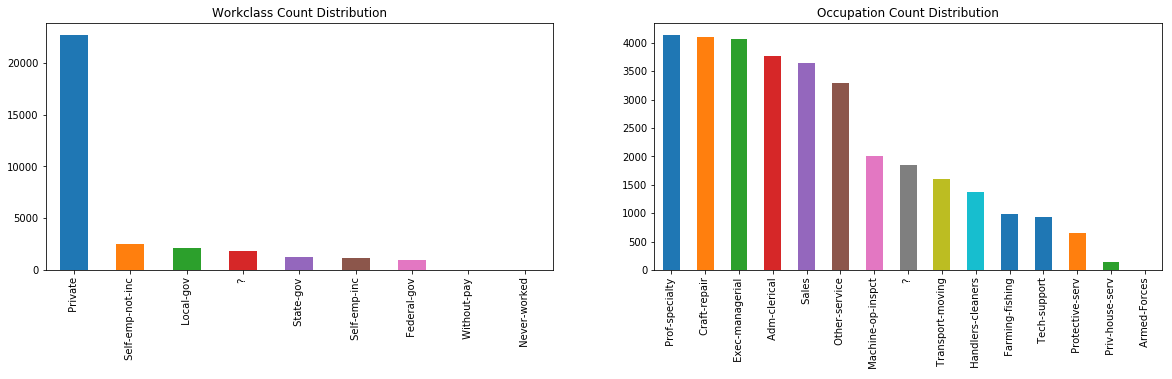

In [34]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1) 
plt.title("Workclass Count Distribution")
train_set['workclass'].value_counts().plot.bar()

plt.subplot(2,2,2) 
plt.title("Occupation Count Distribution")
train_set['occupation'].value_counts().plot.bar()

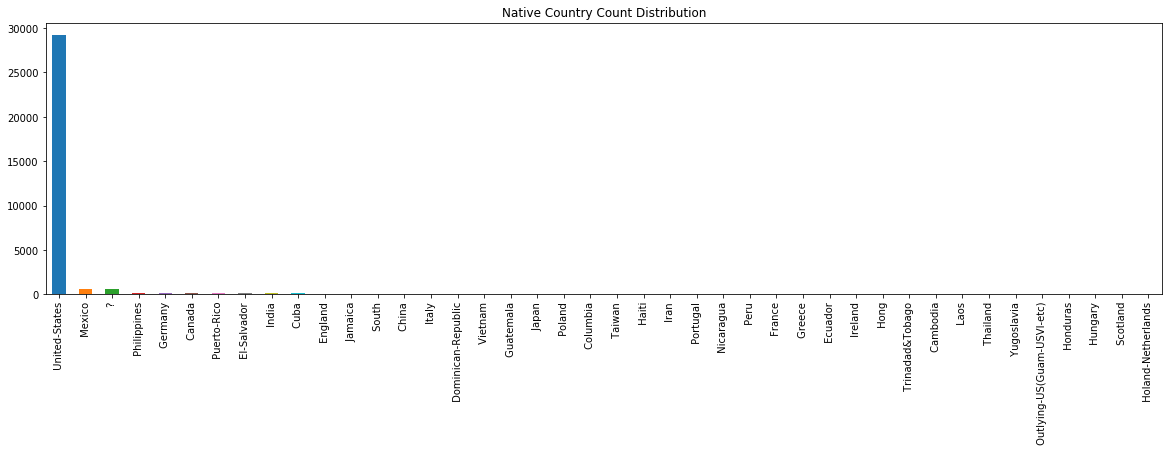

In [35]:
plt.figure(figsize=(20,5))
plt.subplot(1,1,1) 
plt.title("Native Country Count Distribution")
train_set['native_country'].value_counts().plot.bar()

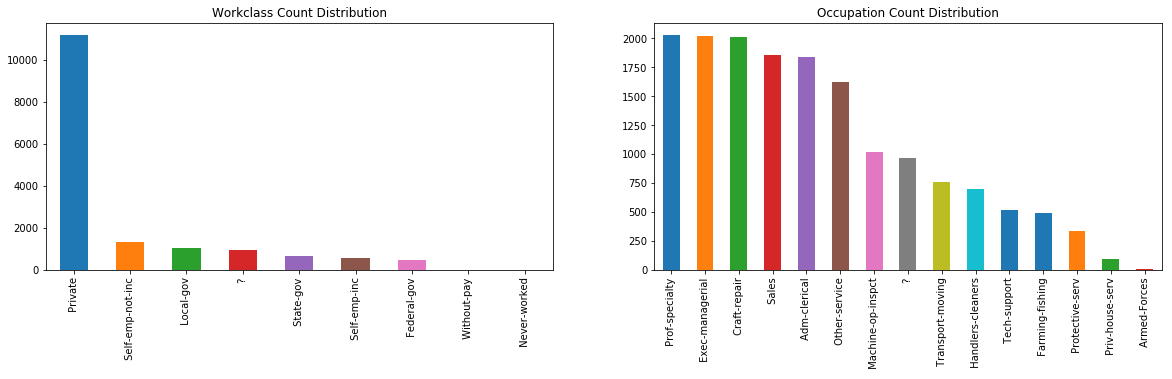

In [36]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1) 
plt.title("Workclass Count Distribution")
test_set['workclass'].value_counts().plot.bar()

plt.subplot(2,2,2) 
plt.title("Occupation Count Distribution")
test_set['occupation'].value_counts().plot.bar()

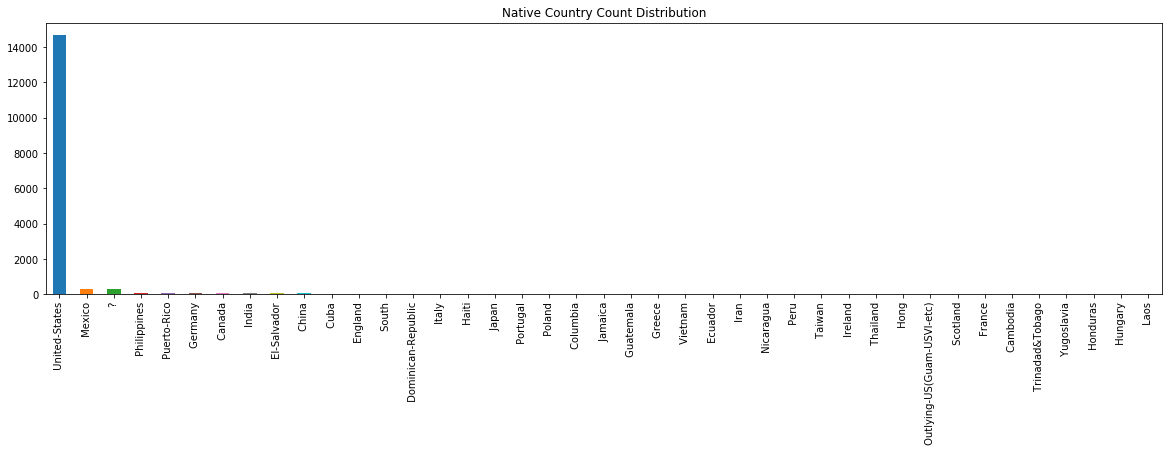

In [37]:
plt.figure(figsize=(20,5))
plt.subplot(1,1,1) 
plt.title("Native Country Count Distribution")
test_set['native_country'].value_counts().plot.bar()

In [38]:
train_set[train_set.workclass.str.contains("\?")].head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
27,54,?,180211,Some-college,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
61,32,?,293936,7th-8th,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,<=50K
69,25,?,200681,Some-college,10,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
77,67,?,212759,10th,6,Married-civ-spouse,?,Husband,White,Male,0,0,2,United-States,<=50K
106,17,?,304873,10th,6,Never-married,?,Own-child,White,Female,34095,0,32,United-States,<=50K


In [39]:
test_set[test_set.workclass.str.contains("\?")].head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K.
13,58,?,299831,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,35,United-States,<=50K.
22,72,?,132015,7th-8th,4,Divorced,?,Not-in-family,White,Female,0,0,6,United-States,<=50K.
35,65,?,191846,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,40,United-States,<=50K.


In [40]:
(train_set.loc[(train_set==" ?").any(axis=1),cat_cols].shape[0]/train_set.shape[0])*100

7.367709836921471

In [41]:
(test_set.loc[(test_set==" ?").any(axis=1),cat_cols].shape[0]/test_set.shape[0])*100

7.499539340335361

***If we drop the rows containing ? values, we incur a data loss of approximately 7.5% data loss in the train_set and the test_set. Therefore we choose to drop it***

In [42]:
train_set.drop(train_set.loc[(train_set==" ?").any(axis=1)].index, inplace= True)
train_set.shape[0]

30162

In [43]:
test_set.drop(test_set.loc[(test_set==" ?").any(axis=1)].index, inplace= True)
test_set.shape[0]

15060

In [44]:
test_set.loc[(test_set==" ?").any(axis=1),cat_cols].shape[0]/test_set.shape[0]

0.0

# Get Basic Statistical Information

In [45]:
train_set.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,30162.000000,3.016200e+04,30162.000000,30162.000000,30162.000000,30162.000000
mean,38.437902,1.897938e+05,10.121312,1092.007858,88.372489,40.931238
std,13.134665,1.056530e+05,2.549995,7406.346497,404.298370,11.979984
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.176272e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.784250e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.376285e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [46]:
train_set.describe(include='object')

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,wage_class
count,30162,30162,30162,30162,30162,30162,30162,30162,30162
unique,7,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22286,9840,14065,4038,12463,25933,20380,27504,22654


In [47]:
test_set.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,15060.000000,1.506000e+04,15060.000000,15060.000000,15060.000000,15060.000000
mean,38.768327,1.896164e+05,10.112749,1120.301594,89.041899,40.951594
std,13.380676,1.056150e+05,2.558727,7703.181842,406.283245,12.062831
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.166550e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.779550e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.385888e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,3770.000000,99.000000


In [48]:
test_set.describe(include='object')

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,wage_class
count,15060,15060,15060,15060,15060,15060,15060,15060,15060
unique,7,16,7,14,6,5,2,40,2
top,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K.
freq,11021,4943,6990,1992,6203,12970,10147,13788,11360


In [49]:
train_set.corr()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
age,1.000000,-0.076511,0.043526,0.080154,0.060165,0.101599
fnlwgt,-0.076511,1.000000,-0.044992,0.000422,-0.009750,-0.022886
education_num,0.043526,-0.044992,1.000000,0.124416,0.079646,0.152522
capital_gain,0.080154,0.000422,0.124416,1.000000,-0.032229,0.080432
capital_loss,0.060165,-0.009750,0.079646,-0.032229,1.000000,0.052417
hours_per_week,0.101599,-0.022886,0.152522,0.080432,0.052417,1.000000


In [50]:
test_set.corr()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
age,1.000000,-0.074375,0.026123,0.078760,0.057745,0.102758
fnlwgt,-0.074375,1.000000,-0.036010,-0.012839,0.006421,-0.010306
education_num,0.026123,-0.036010,1.000000,0.131750,0.085817,0.133691
capital_gain,0.078760,-0.012839,0.131750,1.000000,-0.031876,0.090501
capital_loss,0.057745,0.006421,0.085817,-0.031876,1.000000,0.057712
hours_per_week,0.102758,-0.010306,0.133691,0.090501,0.057712,1.000000


# Explore Data

## Uni-variate

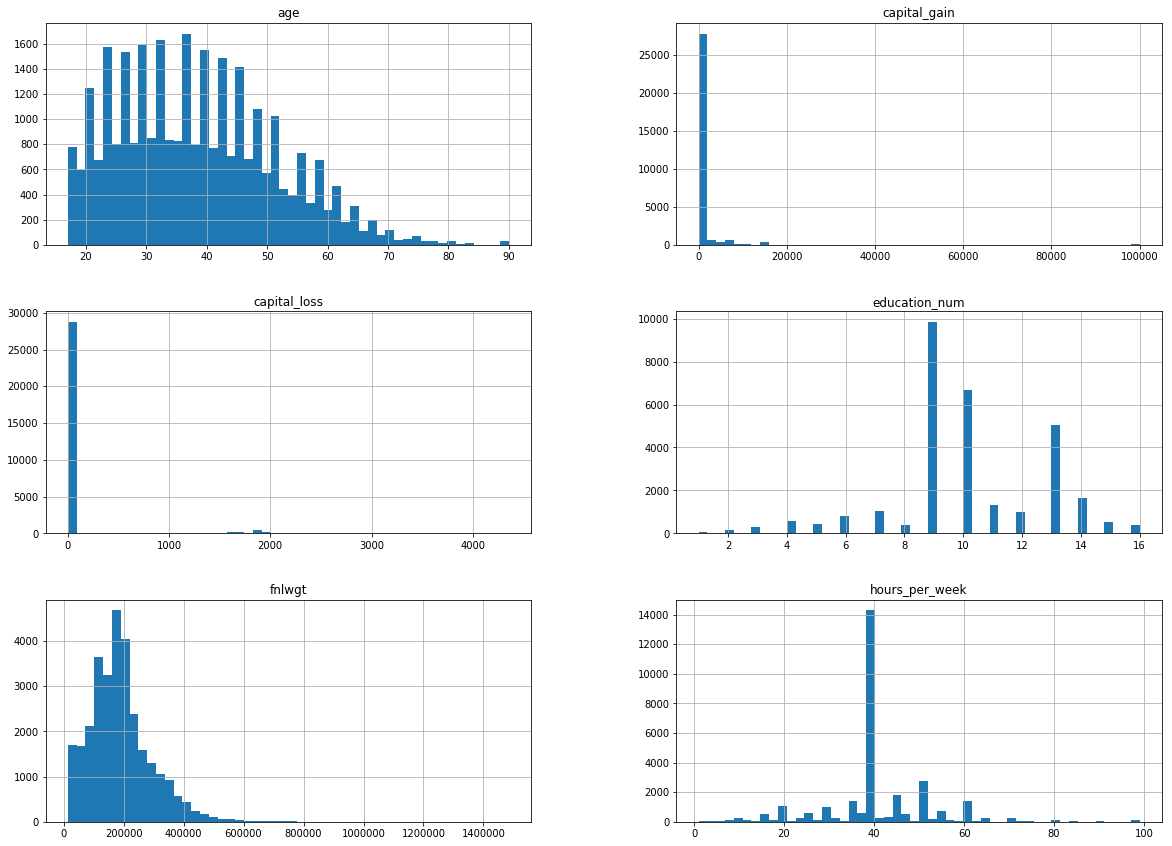

In [51]:
train_set[num_cols].hist(bins=50, figsize=(20,20), layout=(4,2))
plt.show()

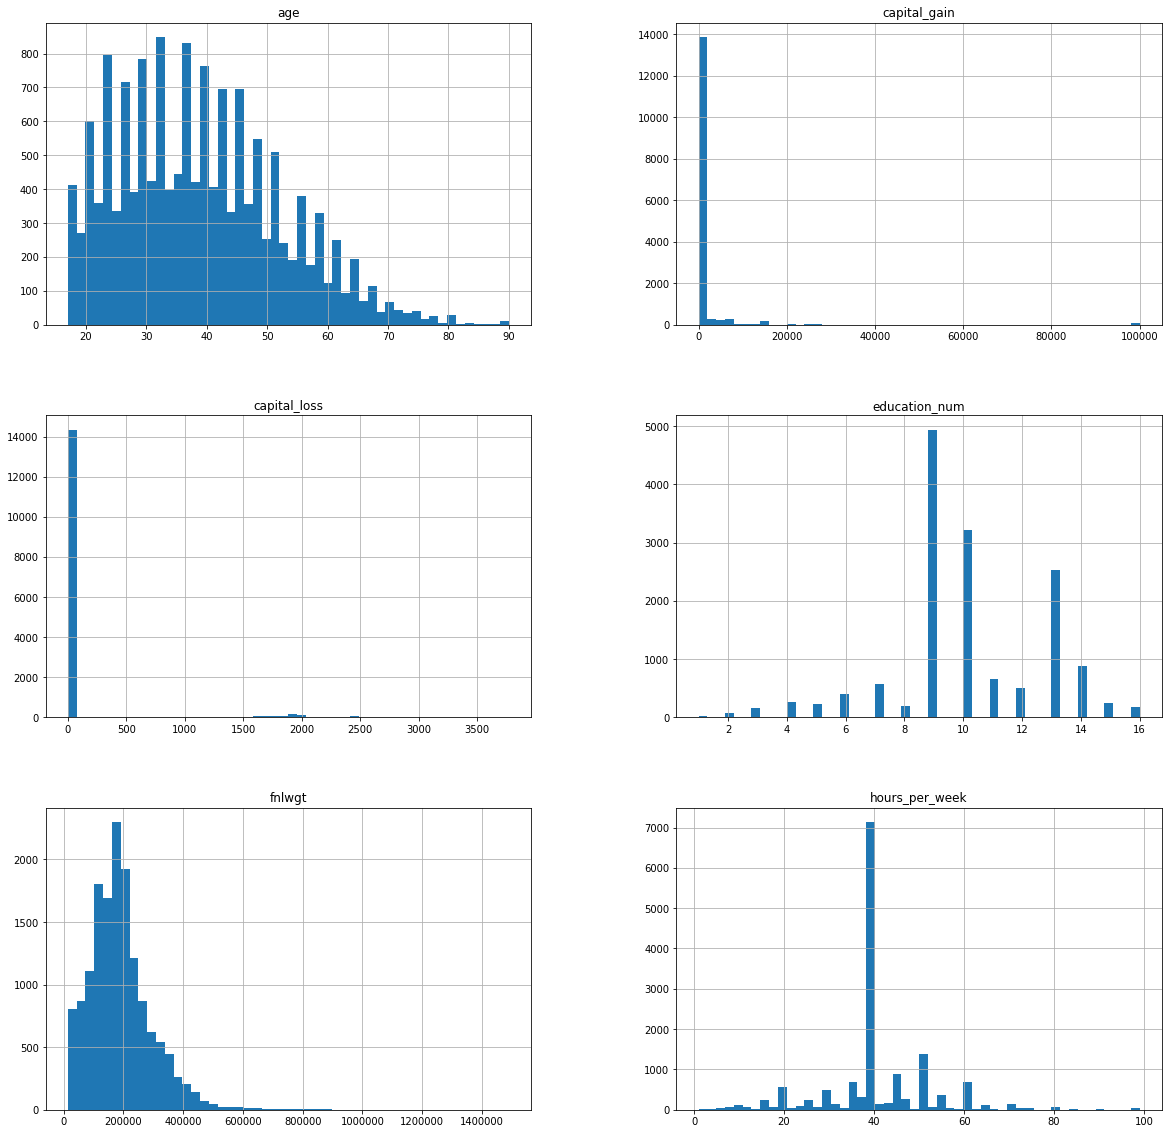

In [52]:
test_set[num_cols].hist(bins=50, figsize=(20,20), layout=(3,2))
plt.show()

### Categorical Columns

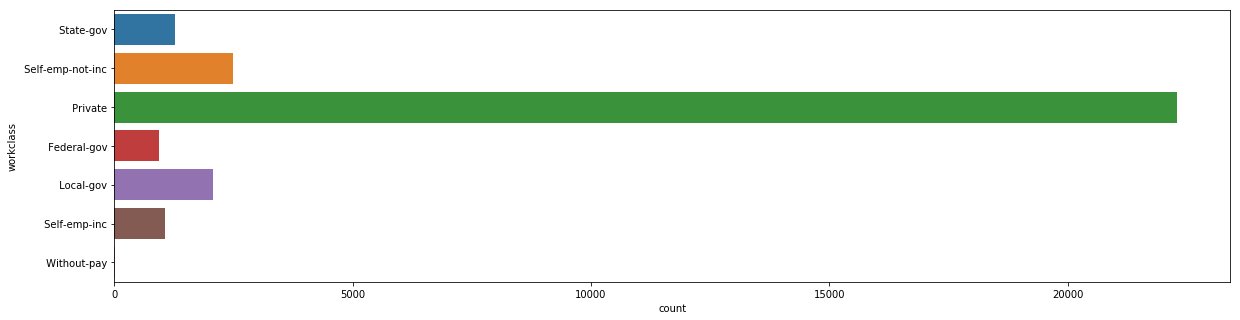

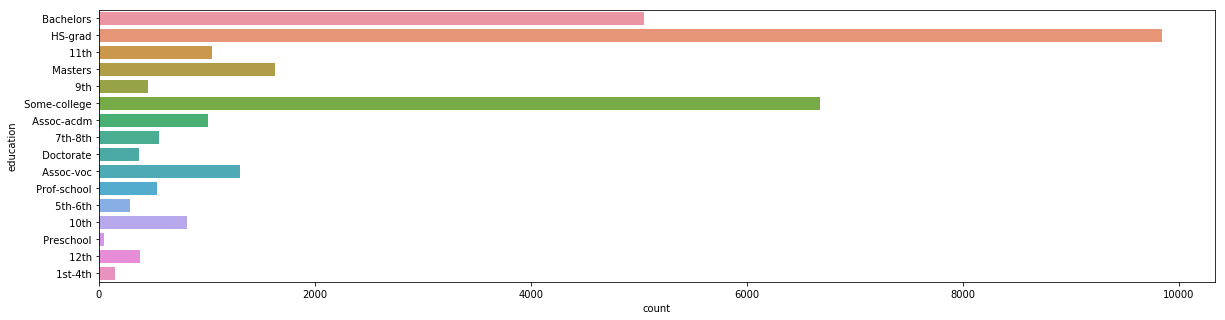

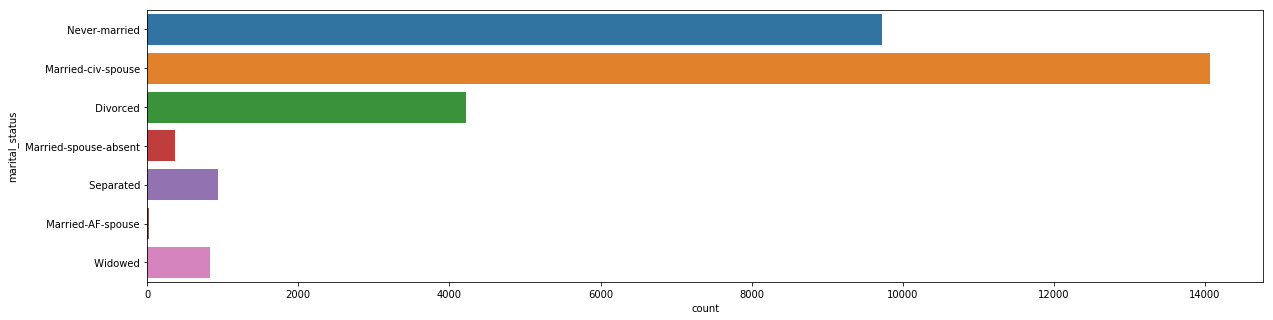

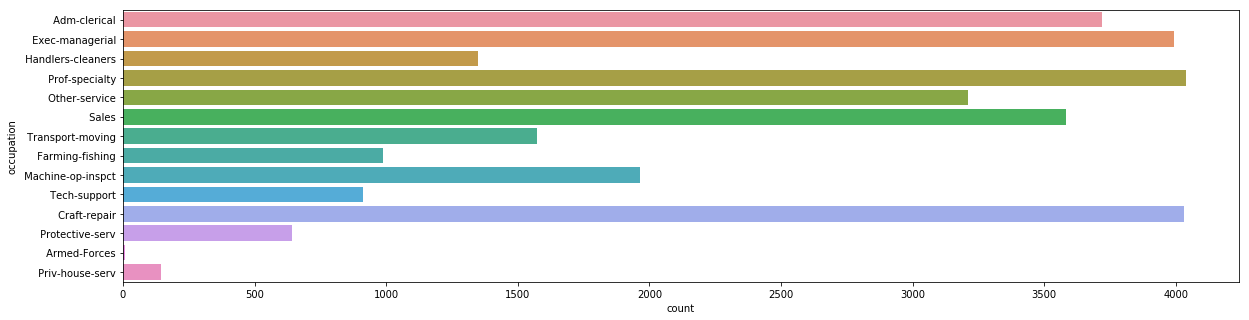

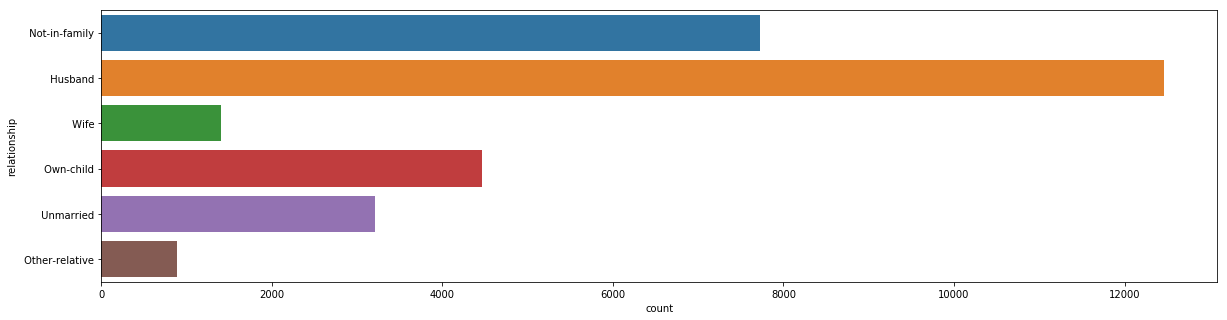

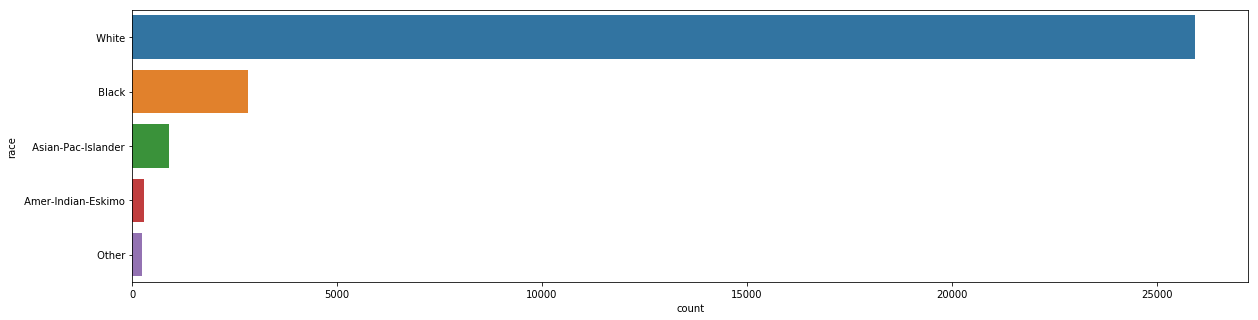

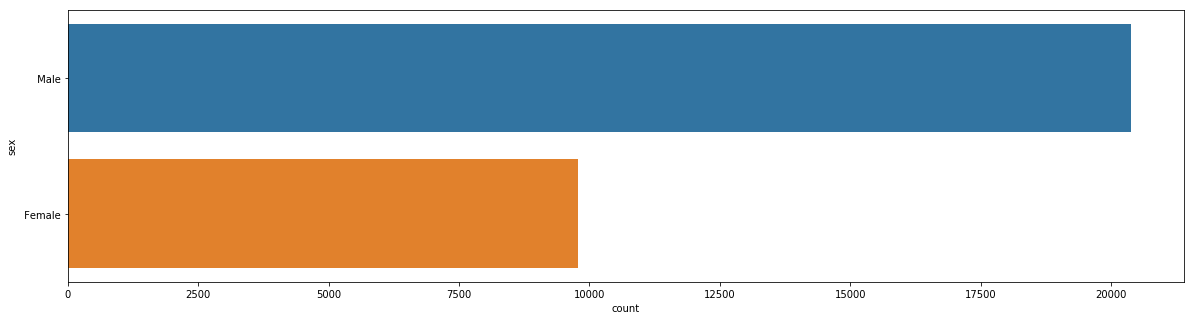

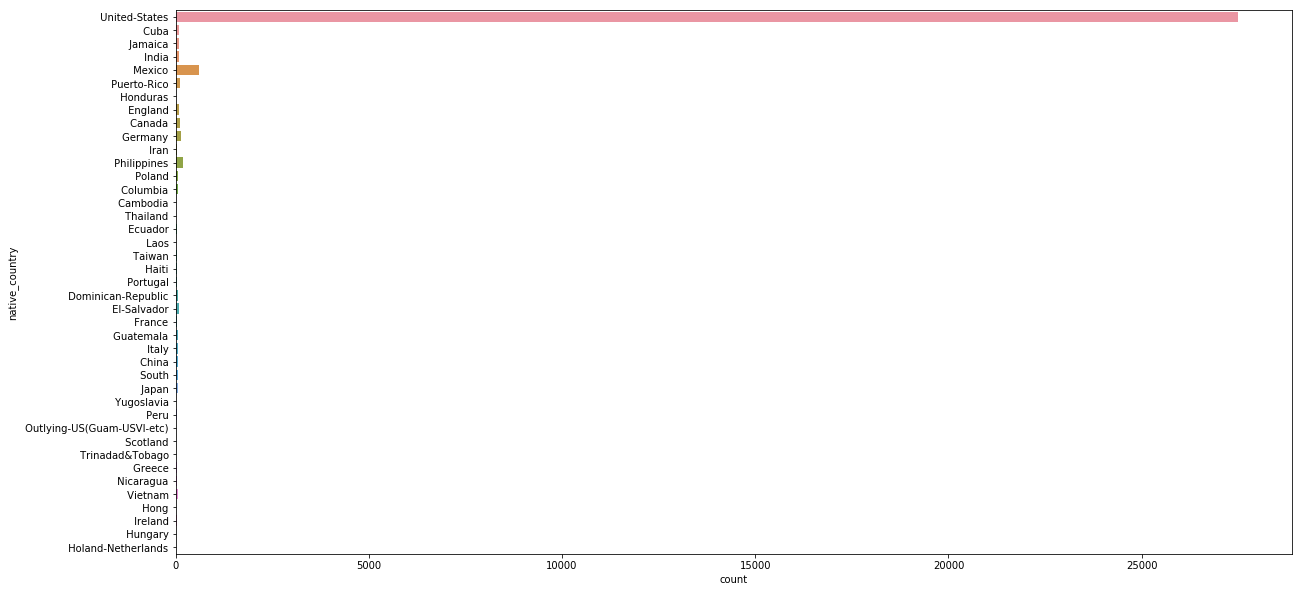

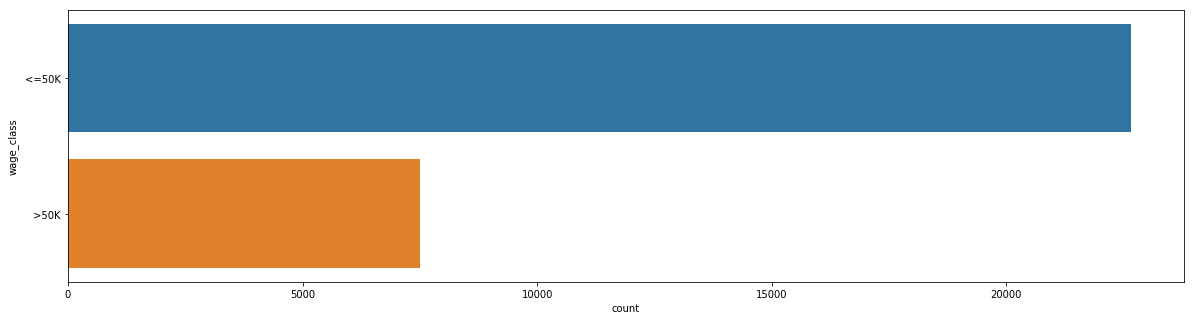

In [53]:
for i, col in enumerate(cat_cols):
    if(col!='native_country'):
        plt.figure(i,figsize = (20,5))
        sns.countplot(y=col, data=train_set,)
    else:
        plt.figure(i,figsize = (20,10))
        sns.countplot(y=col, data=train_set)

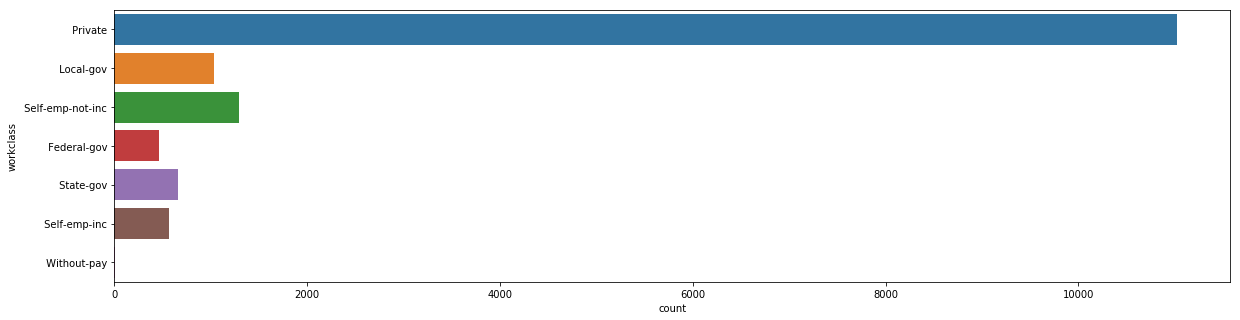

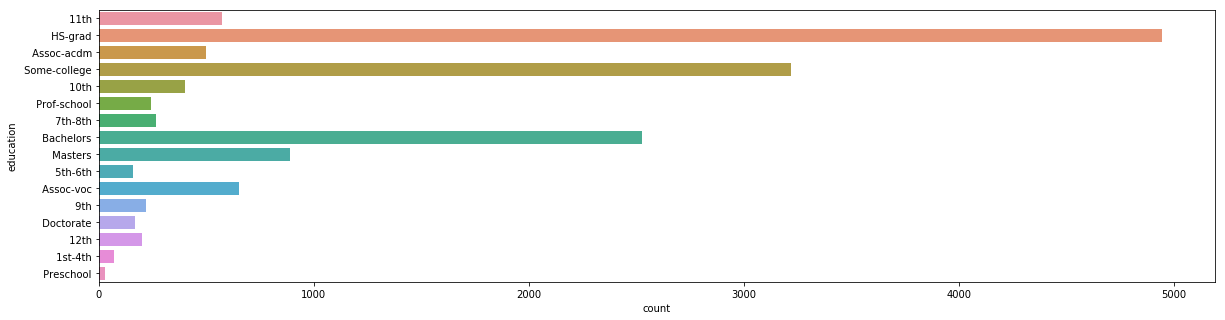

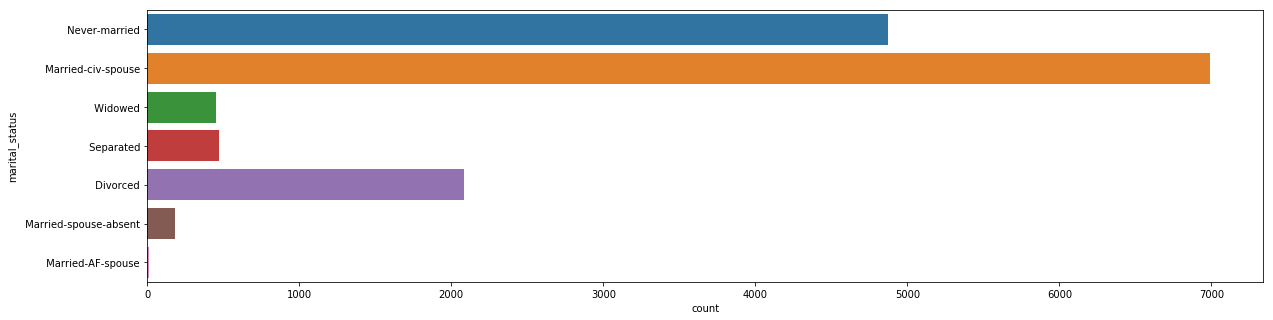

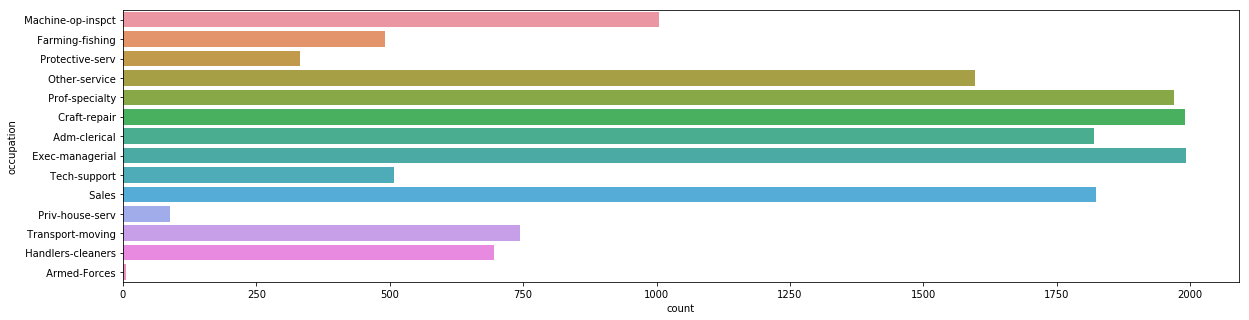

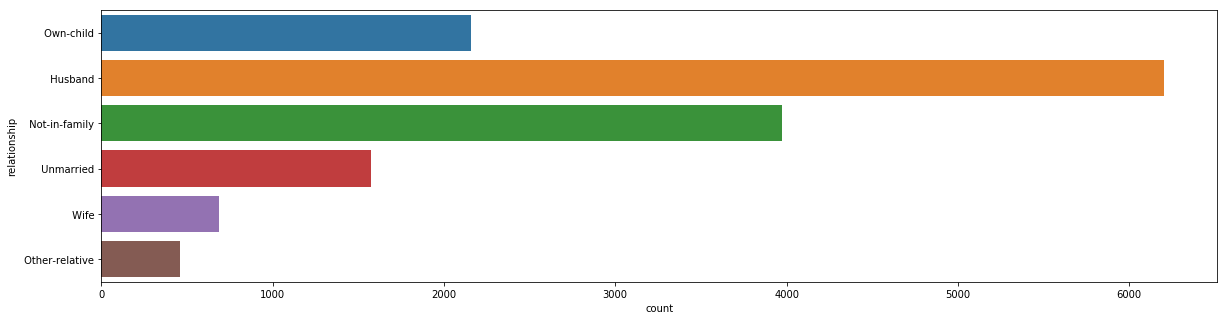

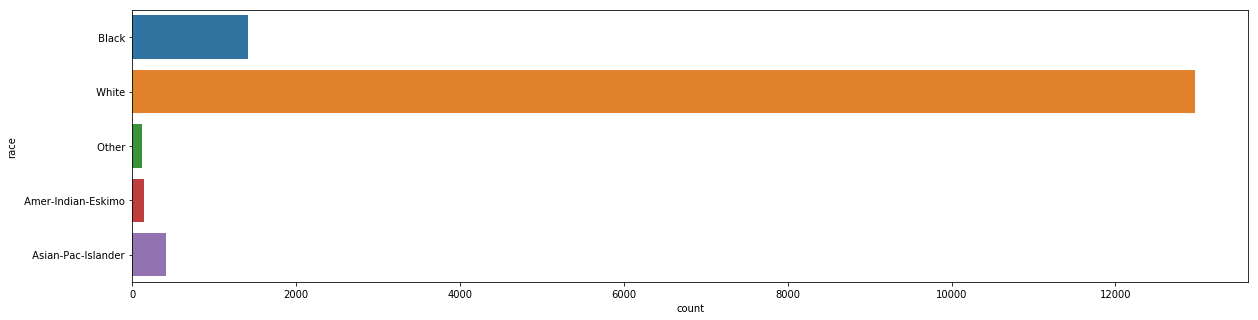

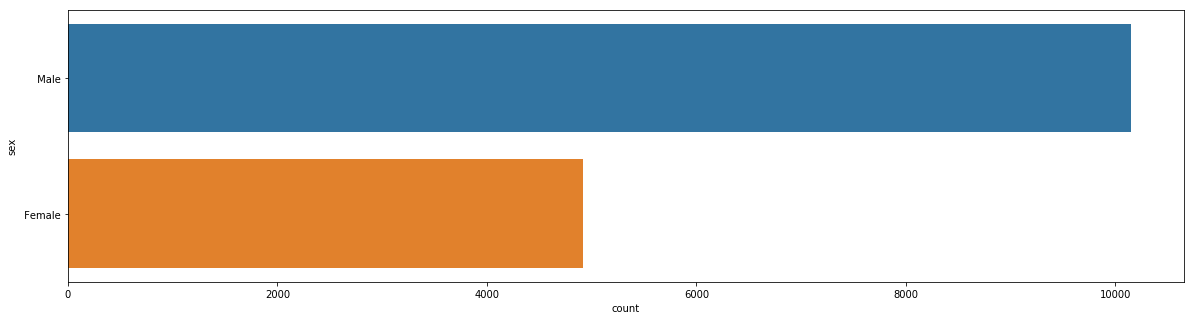

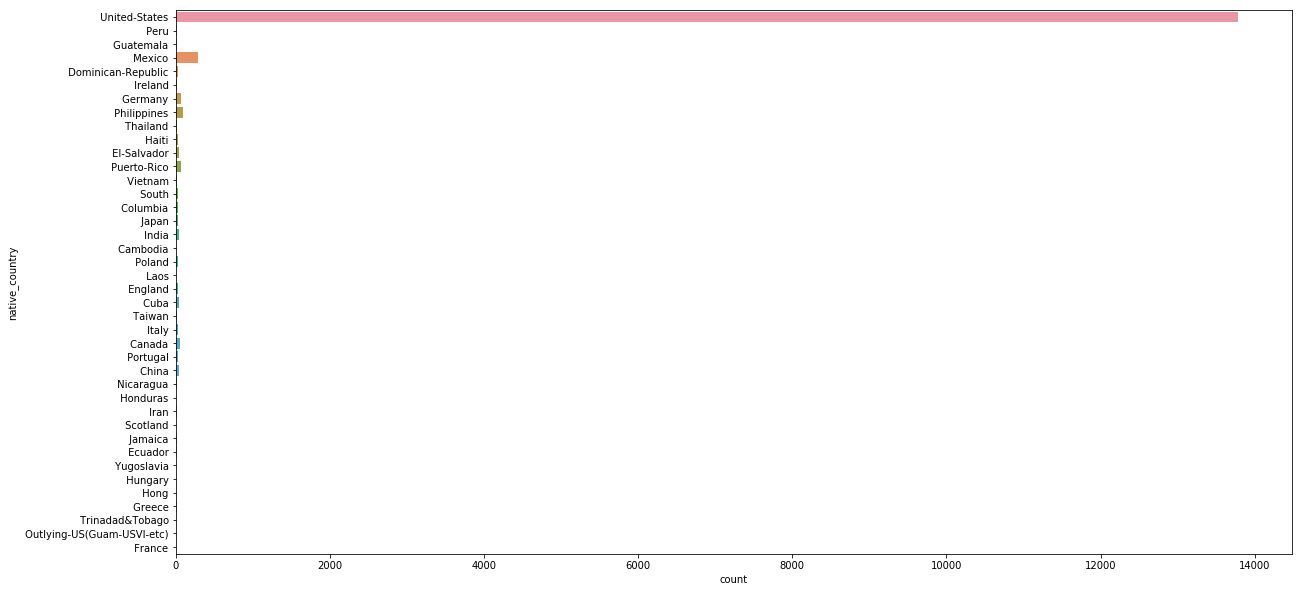

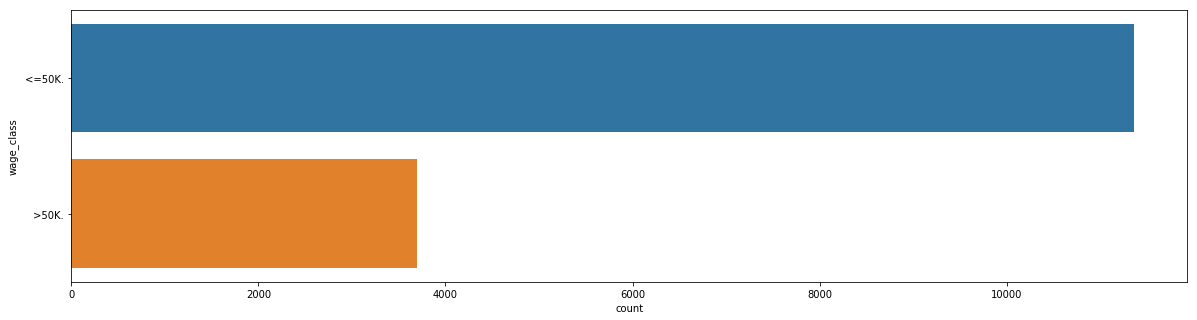

In [54]:
for i, col in enumerate(cat_cols):
    if(col!='native_country'):
        plt.figure(i,figsize = (20,5))
        sns.countplot(y=col, data=test_set)
    else:
        plt.figure(i,figsize = (20,10))
        sns.countplot(y=col, data=test_set)

## Bi-variate

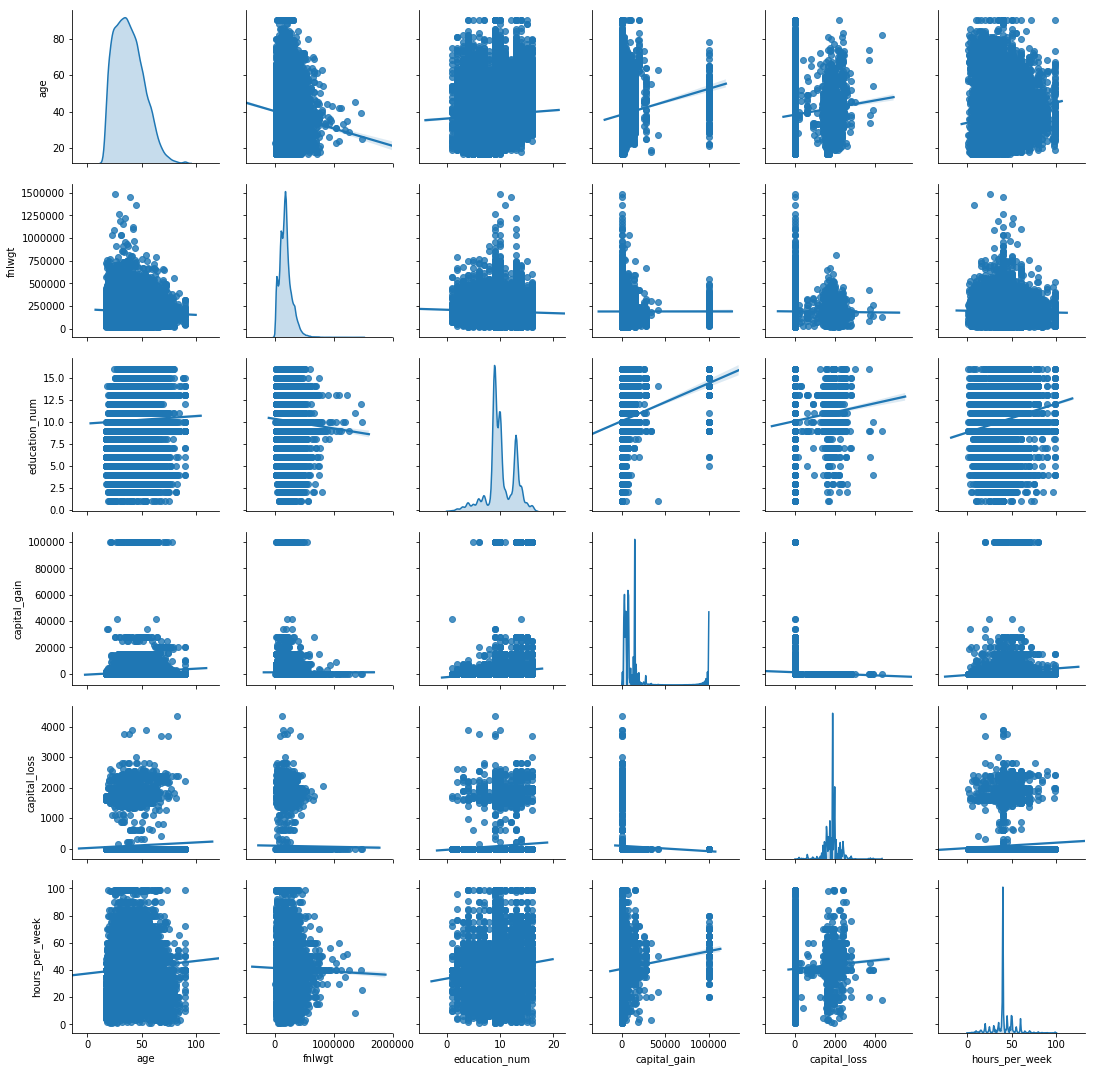

In [55]:
sns.pairplot(train_set[num_cols],kind ='reg',diag_kind='kde')

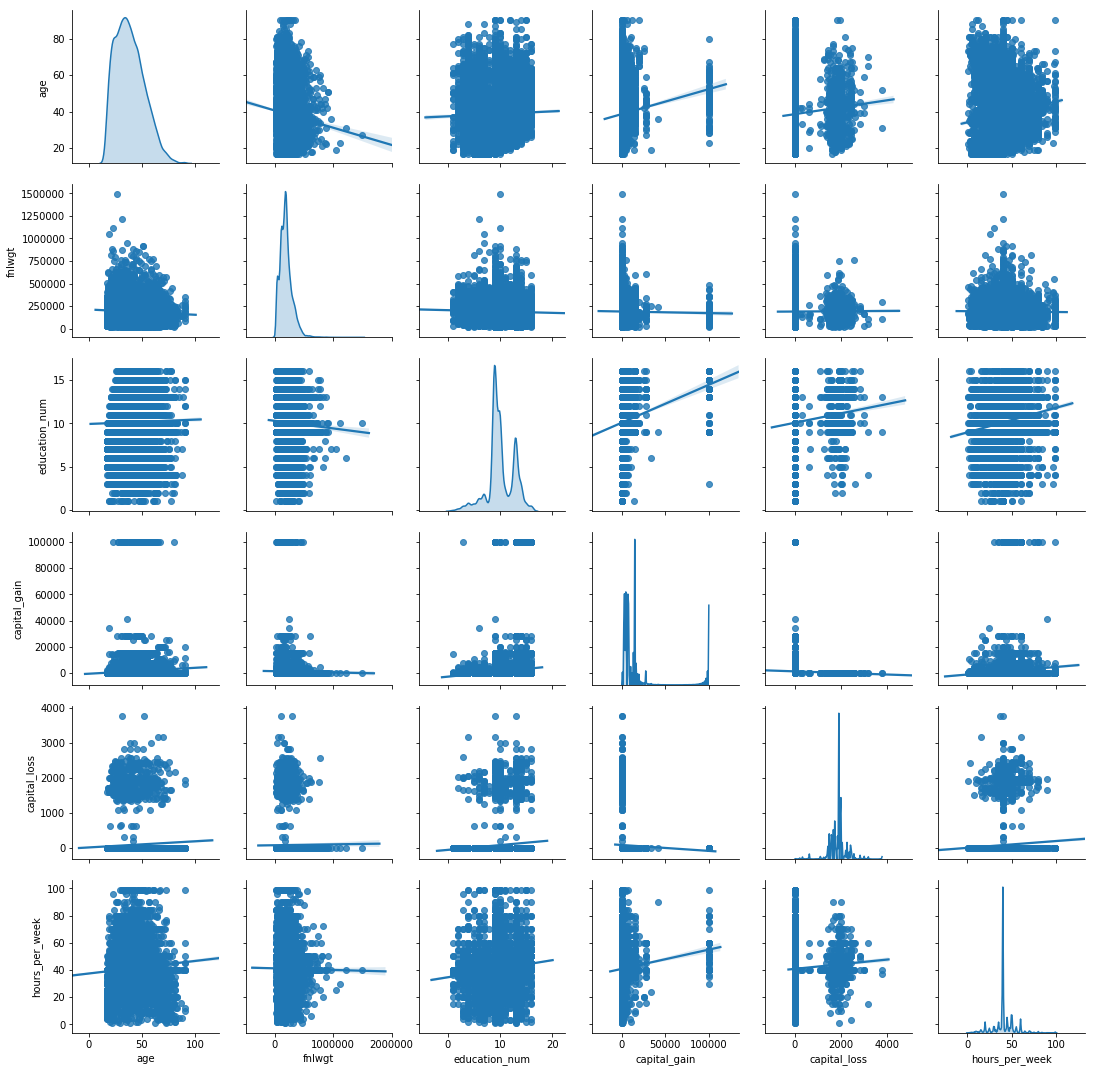

In [56]:
sns.pairplot(test_set[num_cols],kind ='reg',diag_kind='kde')

***None of the numerical columns are strongly correlated with each other, either in train_set or test_set. However, it is interesting to note that education_num is more correlated with capital_gain than capital_loss***

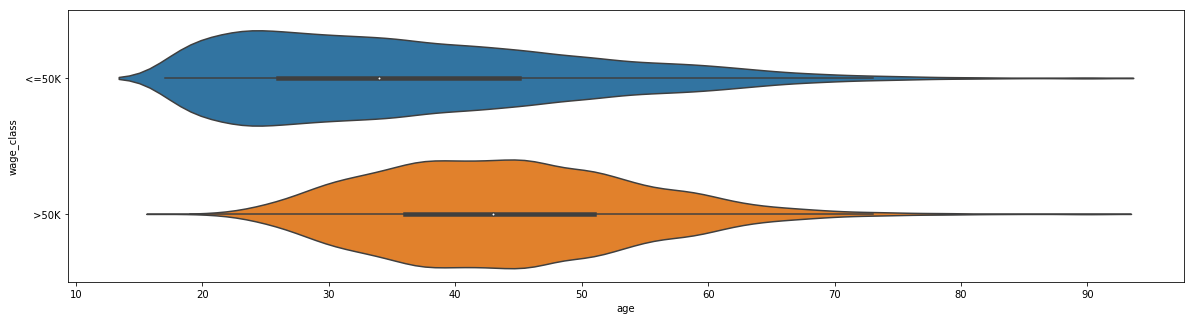

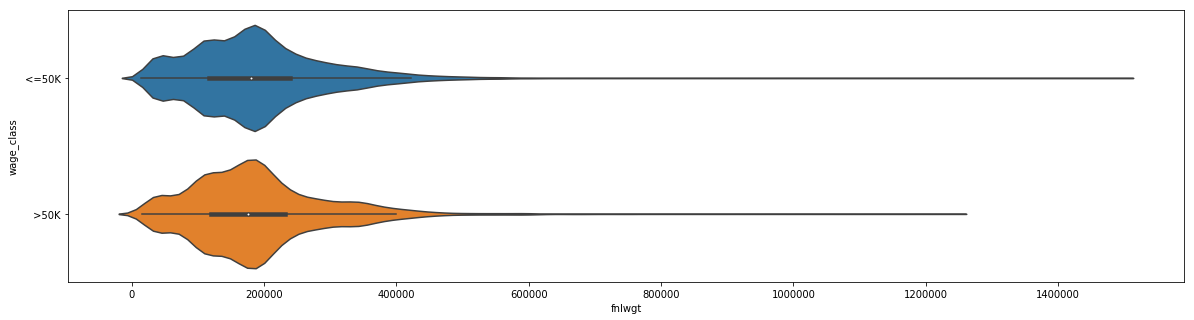

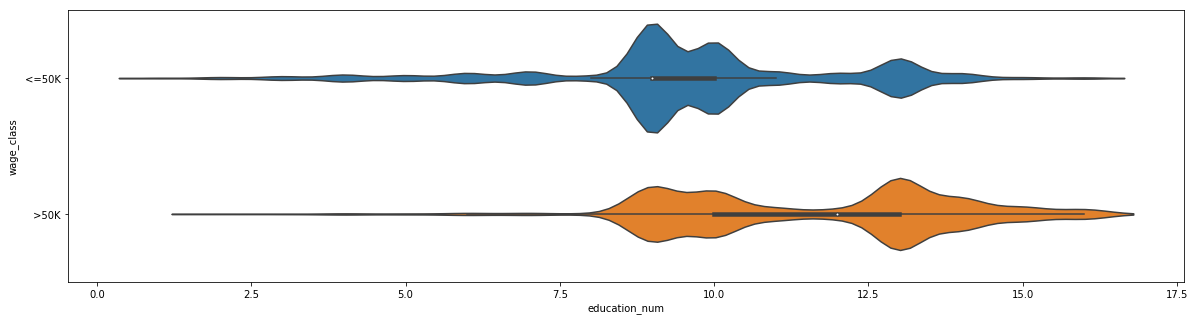

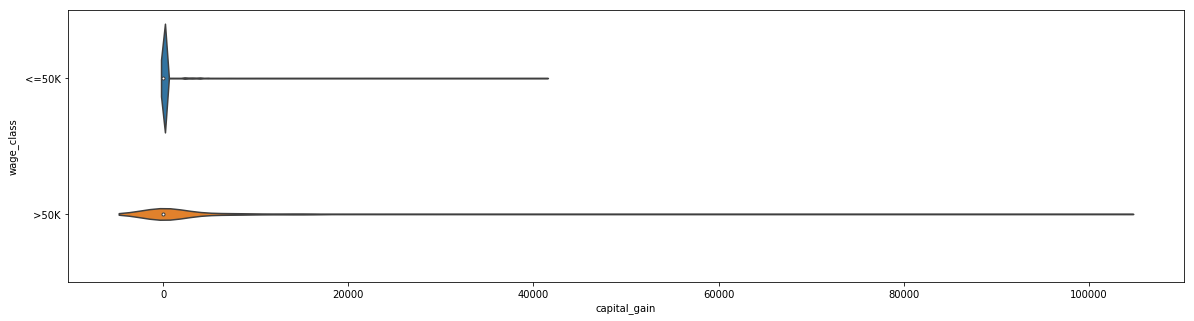

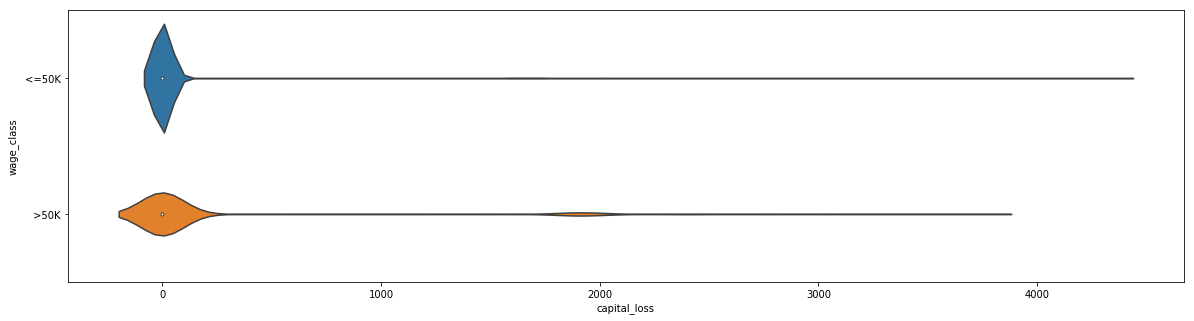

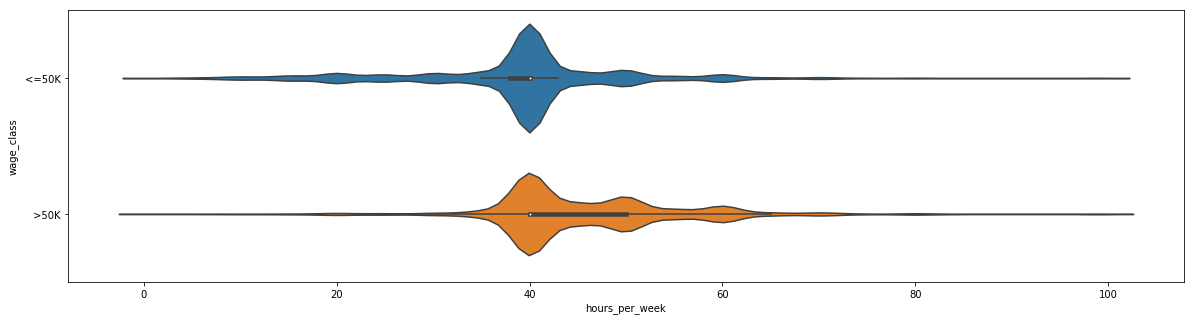

In [57]:
for i, col in enumerate(num_cols):
    plt.figure(i,figsize = (20,5))
    sns.violinplot(x=col,y='wage_class', data=train_set)

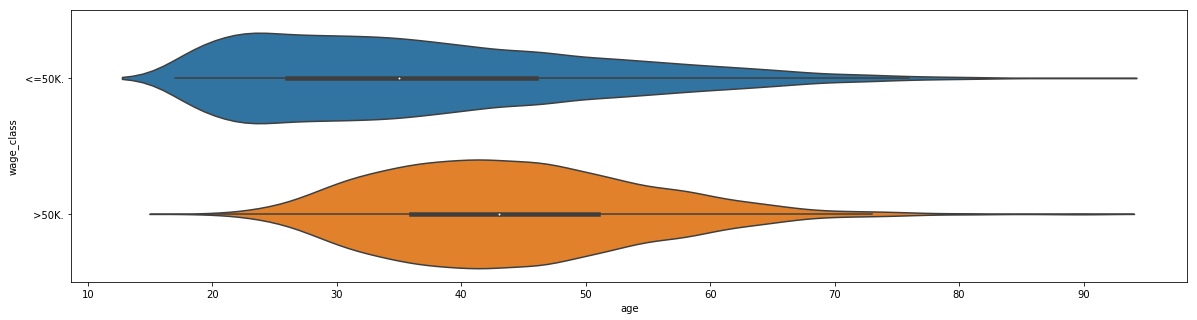

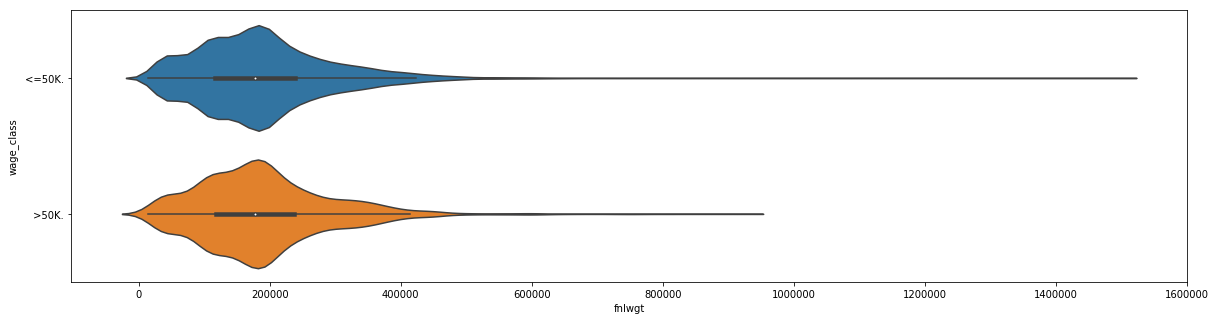

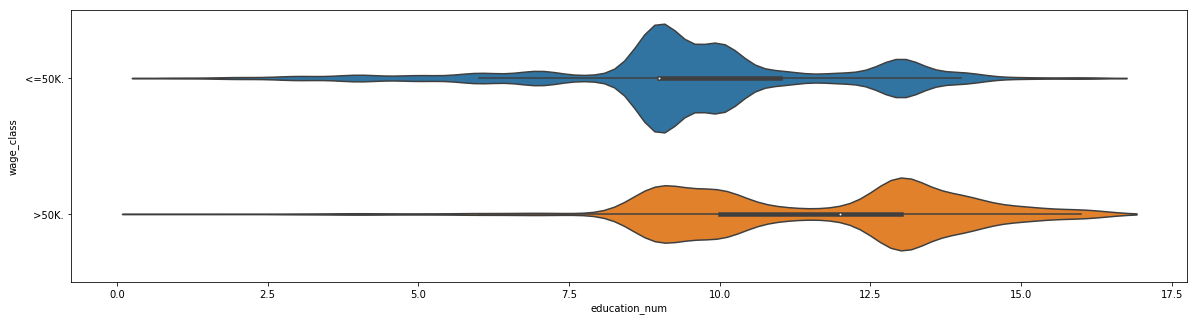

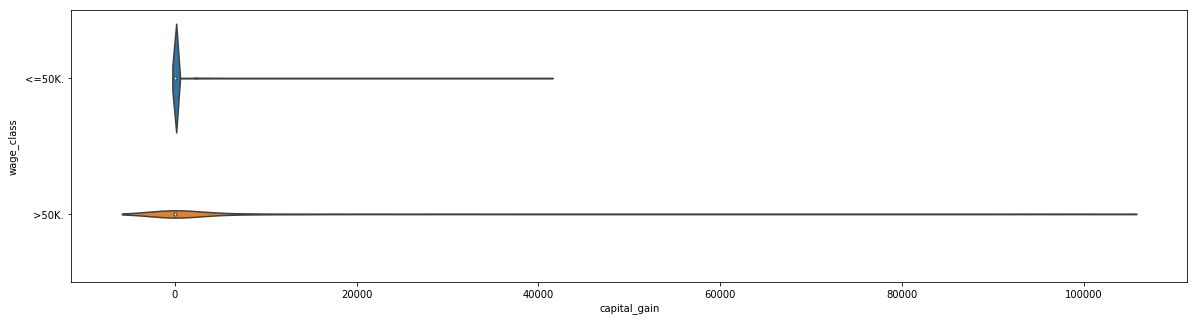

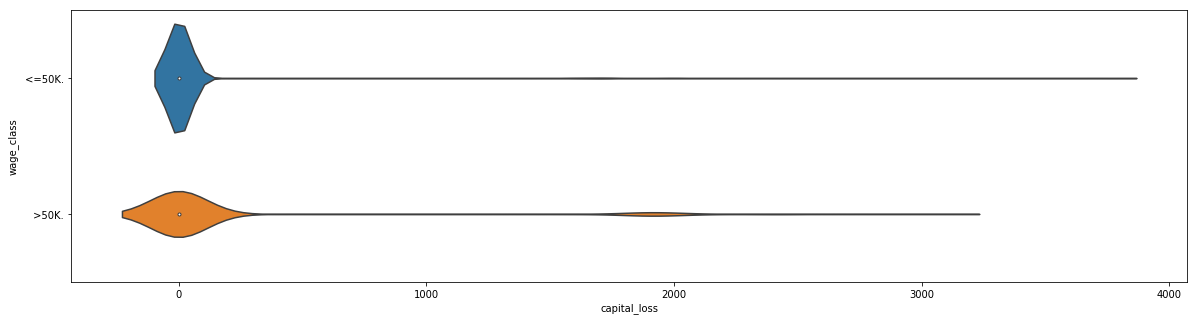

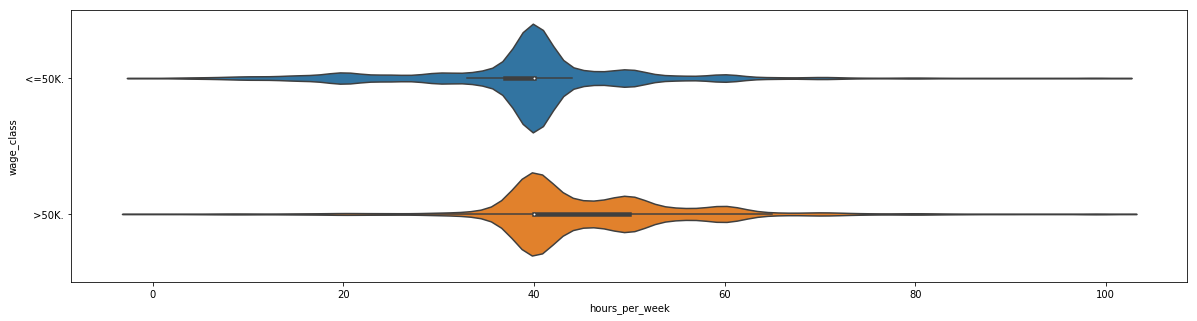

In [58]:
for i, col in enumerate(num_cols):
    plt.figure(i,figsize = (20,5))
    sns.violinplot(x=col,y='wage_class', data=test_set)

## Multi-variate

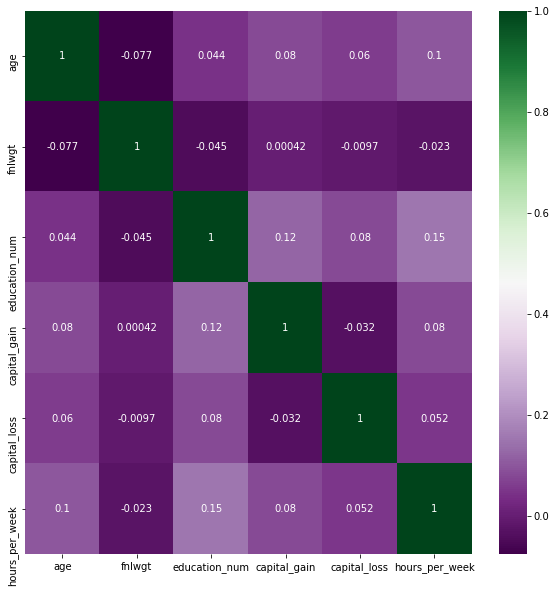

In [59]:
plt.figure(figsize=(10,10))
sns.heatmap(train_set.corr(), annot = True,cmap= "PRGn")

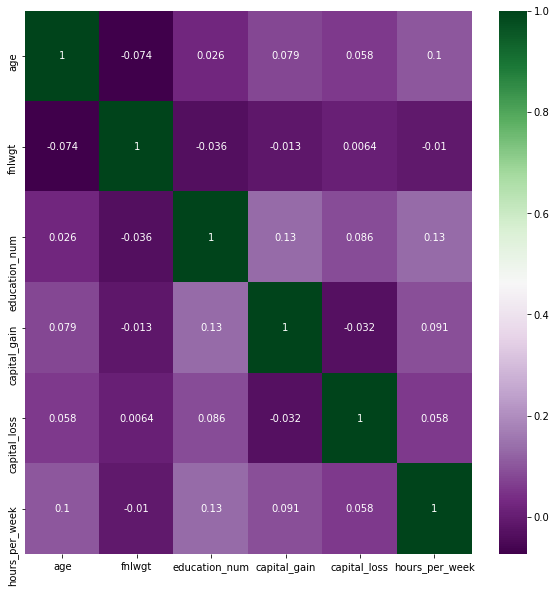

In [60]:
plt.figure(figsize=(10,10))
sns.heatmap(test_set.corr(), annot = True,cmap= "PRGn")

# Engineer Features

## Encode Categorical Columns

In [61]:
for col in train_set.columns: # Loop through all columns in the dataframe
    if train_set[col].dtype == 'object': # Only apply for columns with categorical strings
        train_set[col] = pd.Categorical(train_set[col]).codes # Replace strings with an integer

In [62]:
for col in test_set.columns: # Loop through all columns in the dataframe
    if test_set[col].dtype == 'object': # Only apply for columns with categorical strings
        test_set[col] = pd.Categorical(test_set[col]).codes # Replace strings with an integer

# Generate Input Vector X and Output Y, and Split the Data for Training and Testing

In [63]:
x_train = train_set.drop('wage_class', axis =1)
y_train = train_set['wage_class']
x_test = test_set.drop('wage_class', axis =1)
y_test = test_set['wage_class']

In [64]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((30162, 14), (30162,), (15060, 14), (15060,))

# Fit the Base Models and Collect the Metrics

## Logistic Regression

In [65]:
log_res = LogisticRegression()
model_lr = log_res.fit(x_train, y_train)

y_test_pred = model_lr.predict(x_test)

y_test_pred_prob = model_lr.predict_proba(x_test)

# Generate model evaluation metrics for the Logistic Regression
print("Performance metrics of the model for the Logistic Regression")
print("-"*100)
print("Accuracy: ", metrics.accuracy_score(y_test, y_test_pred))
print("Precision Score: ",metrics.precision_score(y_test, y_test_pred))
print("Recall Score: ",metrics.recall_score(y_test, y_test_pred))
print("AUROC Score: ",metrics.roc_auc_score(y_test,  y_test_pred_prob[:,1]))
print()
print("Confusion Matrix:  \n ",metrics.confusion_matrix(y_test, y_test_pred))
print()
print("Classification Report:\n ",metrics.classification_report(y_test, y_test_pred))

Performance metrics of the model for the Logistic Regression
----------------------------------------------------------------------------------------------------
Accuracy:  0.7847941567065073
Precision Score:  0.6284275321768327
Recall Score:  0.3035135135135135
AUROC Score:  0.7567870551008756

Confusion Matrix:  
  [[10696   664]
 [ 2577  1123]]

Classification Report:
               precision    recall  f1-score   support

          0       0.81      0.94      0.87     11360
          1       0.63      0.30      0.41      3700

avg / total       0.76      0.78      0.76     15060



## Other Classifiers

In [66]:
classifiers = [
            ("Logistic Regression - ", LogisticRegression()),
            ("K-Nearest Neighbors - ",  KNeighborsClassifier(2)),
            ("Naive Bayes - ",  GaussianNB()),
            ("Decision Tree - ",  DecisionTreeClassifier(max_depth=5)),
            ("Random Forest - ",  RandomForestClassifier(n_estimators=100)),
            ("AdaBoost - ",  AdaBoostClassifier(n_estimators=100)),
            ("XGBoost - ", XGBClassifier(n_estimators=100,objective='binary:logistic'))]

In [67]:
# Generate model evaluation metrics
for clf in classifiers:
    clf[1].fit(x_train, y_train)
    y_test_pred= clf[1].predict(x_test)
    y_test_pred_prob= clf[1].predict_proba(x_test)
    print(clf[0],
          "\n\t Accuracy: ", metrics.accuracy_score(y_test, y_test_pred),
          "\n\t Precision Score: ",metrics.precision_score(y_test, y_test_pred),
          "\n\t Recall Score: ",metrics.recall_score(y_test, y_test_pred),
          "\n\t AUROC Score: ",metrics.roc_auc_score(y_test,  y_test_pred_prob[:,1]),
          "\n\t Confusion Matrix:  \n ",metrics.confusion_matrix(y_test, y_test_pred),
          "\n\t Classification Report:\n ",metrics.classification_report(y_test, y_test_pred),"\n")

Logistic Regression -  
	 Accuracy:  0.7847941567065073 
	 Precision Score:  0.6284275321768327 
	 Recall Score:  0.3035135135135135 
	 AUROC Score:  0.7567870551008756 
	 Confusion Matrix:  
  [[10696   664]
 [ 2577  1123]] 
	 Classification Report:
               precision    recall  f1-score   support

          0       0.81      0.94      0.87     11360
          1       0.63      0.30      0.41      3700

avg / total       0.76      0.78      0.76     15060
 

K-Nearest Neighbors -  
	 Accuracy:  0.7768924302788844 
	 Precision Score:  0.6010701545778835 
	 Recall Score:  0.27324324324324323 
	 AUROC Score:  0.6567672249714503 
	 Confusion Matrix:  
  [[10689   671]
 [ 2689  1011]] 
	 Classification Report:
               precision    recall  f1-score   support

          0       0.80      0.94      0.86     11360
          1       0.60      0.27      0.38      3700

avg / total       0.75      0.78      0.74     15060
 

Naive Bayes -  
	 Accuracy:  0.7885790172642763 
	 Precisio

# Select Features

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

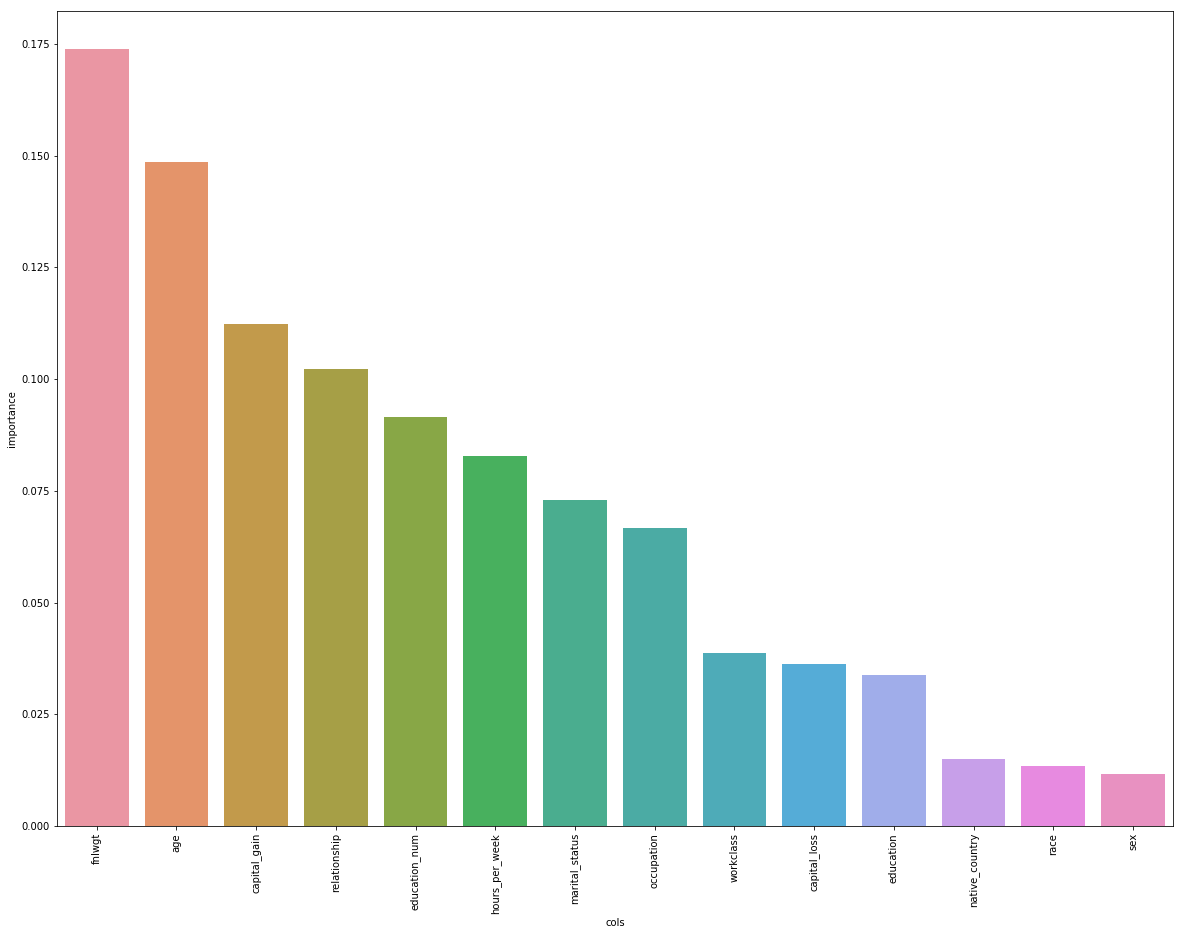

In [68]:
rndf = RandomForestClassifier(n_estimators=150)
rndf.fit(x_train, y_train)
importance = pd.DataFrame.from_dict({'cols':x_train.columns, 'importance': rndf.feature_importances_})
importance = importance.sort_values(by='importance', ascending=False)
plt.figure(figsize=(20,15))
sns.barplot(importance.cols, importance.importance)
plt.xticks(rotation=90)

In [69]:
imp_cols = importance[importance.importance >= 0.03].cols.values
imp_cols

array(['fnlwgt', 'age', 'capital_gain', 'relationship', 'education_num',
       'hours_per_week', 'marital_status', 'occupation', 'workclass',
       'capital_loss', 'education'], dtype=object)

In [70]:
# Generate model evaluation metrics
print("Base Models")
print('-'*60)
accuracy_base = []
precision_base =[]
recall_base = []
model_names = [i[0] for i in classifiers]
for clf in classifiers:
    clf[1].fit(x_train, y_train)
    y_test_pred= clf[1].predict(x_test)
    accuracy_base.append(metrics.accuracy_score(y_test, y_test_pred))
    precision_base.append(metrics.precision_score(y_test, y_test_pred))
    recall_base.append(metrics.recall_score(y_test, y_test_pred))
    print(clf[0],
          "\n\t Accuracy: ", metrics.accuracy_score(y_test, y_test_pred),
          "\n\t Precision Score: ",metrics.precision_score(y_test, y_test_pred),
          "\n\t Recall Score: ",metrics.recall_score(y_test, y_test_pred))

Base Models
------------------------------------------------------------
Logistic Regression -  
	 Accuracy:  0.7847941567065073 
	 Precision Score:  0.6284275321768327 
	 Recall Score:  0.3035135135135135
K-Nearest Neighbors -  
	 Accuracy:  0.7768924302788844 
	 Precision Score:  0.6010701545778835 
	 Recall Score:  0.27324324324324323
Naive Bayes -  
	 Accuracy:  0.7885790172642763 
	 Precision Score:  0.6469248291571754 
	 Recall Score:  0.307027027027027
Decision Tree -  
	 Accuracy:  0.8416998671978752 
	 Precision Score:  0.7690106295993459 
	 Recall Score:  0.5083783783783784
Random Forest -  
	 Accuracy:  0.851394422310757 
	 Precision Score:  0.7376462938881665 
	 Recall Score:  0.6132432432432432
AdaBoost -  
	 Accuracy:  0.8594289508632138 
	 Precision Score:  0.7609627431585888 
	 Recall Score:  0.6237837837837837
XGBoost -  
	 Accuracy:  0.8615537848605578 
	 Precision Score:  0.7920433996383364 
	 Recall Score:  0.5918918918918918


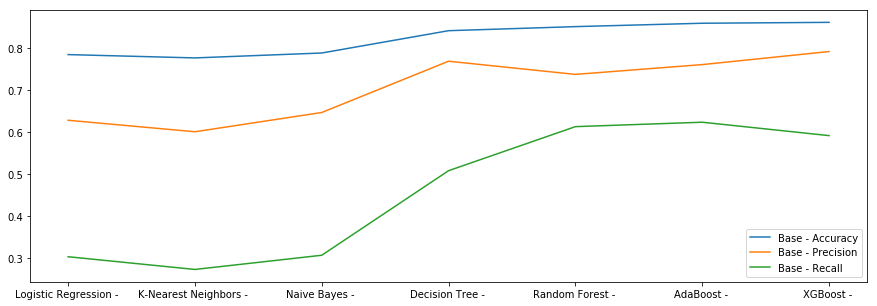

In [71]:
# Plotting the classification metrics for all the base models
plt.figure(figsize=(15,5))
plt.plot(model_names , accuracy_base, label = "Base - Accuracy")
plt.plot(model_names , precision_base, label = "Base - Precision")
plt.plot(model_names , recall_base, label = "Base - Recall")
plt.legend()
plt.show()


In [72]:
# Generate model evaluation metrics
print("Models generated with features having feature importances threshold >= 0.03")
print('-'*60)
accuracy_thresh_03 = []
precision_thresh_03 =[]
recall_thresh_03 = []
for clf in classifiers:
    clf[1].fit(x_train[imp_cols], y_train)
    y_test_pred= clf[1].predict(x_test[imp_cols])
    accuracy_thresh_03.append(metrics.accuracy_score(y_test, y_test_pred))
    precision_thresh_03.append(metrics.precision_score(y_test, y_test_pred))
    recall_thresh_03.append(metrics.recall_score(y_test, y_test_pred)) 
    print(clf[0],
          "\n\t Accuracy: ", metrics.accuracy_score(y_test, y_test_pred),
          "\n\t Precision Score: ",metrics.precision_score(y_test, y_test_pred),
          "\n\t Recall Score: ",metrics.recall_score(y_test, y_test_pred))

Models generated with features having feature importances threshold >= 0.03
------------------------------------------------------------
Logistic Regression -  
	 Accuracy:  0.7926294820717131 
	 Precision Score:  0.7077033837293016 
	 Recall Score:  0.2656756756756757
K-Nearest Neighbors -  
	 Accuracy:  0.7768260292164675 
	 Precision Score:  0.6002365464222353 
	 Recall Score:  0.2743243243243243
Naive Bayes -  
	 Accuracy:  0.7884462151394422 
	 Precision Score:  0.646188850967008 
	 Recall Score:  0.307027027027027
Decision Tree -  
	 Accuracy:  0.8416998671978752 
	 Precision Score:  0.7690106295993459 
	 Recall Score:  0.5083783783783784
Random Forest -  
	 Accuracy:  0.8487383798140771 
	 Precision Score:  0.725 
	 Recall Score:  0.6191891891891892
AdaBoost -  
	 Accuracy:  0.8595617529880478 
	 Precision Score:  0.7694661679700782 
	 Recall Score:  0.6116216216216216
XGBoost -  
	 Accuracy:  0.8611553784860557 
	 Precision Score:  0.7945807396558038 
	 Recall Score:  0.5864864

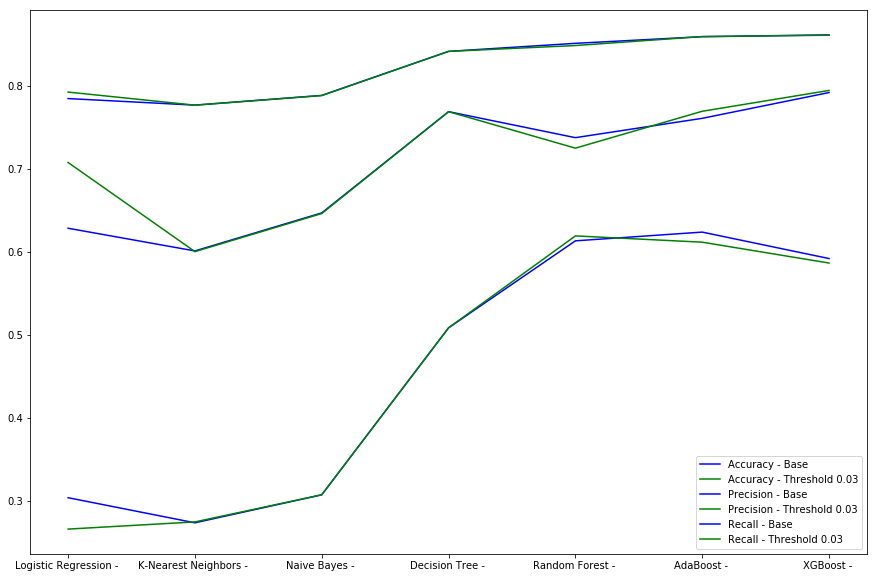

In [73]:
# Plotting the classification metrics for all the base models and models generated from features which have feature importance >=0.03

plt.figure(figsize=(15,10))
plt.plot(model_names , accuracy_base, label = "Accuracy - Base",c = 'blue')
plt.plot(model_names , accuracy_thresh_03, label = "Accuracy - Threshold 0.03", c = 'green')
 
plt.plot(model_names , precision_base, label = "Precision - Base",c = 'blue')
plt.plot(model_names , precision_thresh_03, label = "Precision - Threshold 0.03", c = 'green')
 

plt.plot(model_names , recall_base, label = "Recall - Base",c = 'blue')
plt.plot(model_names , recall_thresh_03, label = "Recall - Threshold 0.03", c = 'green')
 
plt.legend()
plt.show()

In [74]:
imp_cols = importance[importance.importance >= 0.014 ].cols.values
imp_cols

array(['fnlwgt', 'age', 'capital_gain', 'relationship', 'education_num',
       'hours_per_week', 'marital_status', 'occupation', 'workclass',
       'capital_loss', 'education', 'native_country'], dtype=object)

In [75]:
# Generate model evaluation metrics
print("Models generated with features having feature importances threshold >= 0.014")
print('-'*60)
accuracy_thresh_014 = []
precision_thresh_014 =[]
recall_thresh_014 = []
     
for clf in classifiers:
    clf[1].fit(x_train[imp_cols], y_train)
    y_test_pred= clf[1].predict(x_test[imp_cols])
    y_test_pred_prob= clf[1].predict_proba(x_test[imp_cols])
    accuracy_thresh_014.append(metrics.accuracy_score(y_test, y_test_pred))
    precision_thresh_014.append(metrics.precision_score(y_test, y_test_pred))
    recall_thresh_014.append(metrics.recall_score(y_test, y_test_pred))
    print(clf[0],
          "\n\t Accuracy: ", metrics.accuracy_score(y_test, y_test_pred),
          "\n\t Precision Score: ",metrics.precision_score(y_test, y_test_pred),
          "\n\t Recall Score: ",metrics.recall_score(y_test, y_test_pred))
         

Models generated with features having feature importances threshold >= 0.014
------------------------------------------------------------
Logistic Regression -  
	 Accuracy:  0.7841301460823373 
	 Precision Score:  0.6252091466815394 
	 Recall Score:  0.302972972972973
K-Nearest Neighbors -  
	 Accuracy:  0.7768924302788844 
	 Precision Score:  0.6010701545778835 
	 Recall Score:  0.27324324324324323
Naive Bayes -  
	 Accuracy:  0.7885790172642763 
	 Precision Score:  0.6469248291571754 
	 Recall Score:  0.307027027027027
Decision Tree -  
	 Accuracy:  0.8417662682602922 
	 Precision Score:  0.7691050265631385 
	 Recall Score:  0.5086486486486487
Random Forest -  
	 Accuracy:  0.848605577689243 
	 Precision Score:  0.7302204928664072 
	 Recall Score:  0.6086486486486486
AdaBoost -  
	 Accuracy:  0.8595617529880478 
	 Precision Score:  0.7694661679700782 
	 Recall Score:  0.6116216216216216
XGBoost -  
	 Accuracy:  0.8617529880478088 
	 Precision Score:  0.7980840088430361 
	 Recall Sco

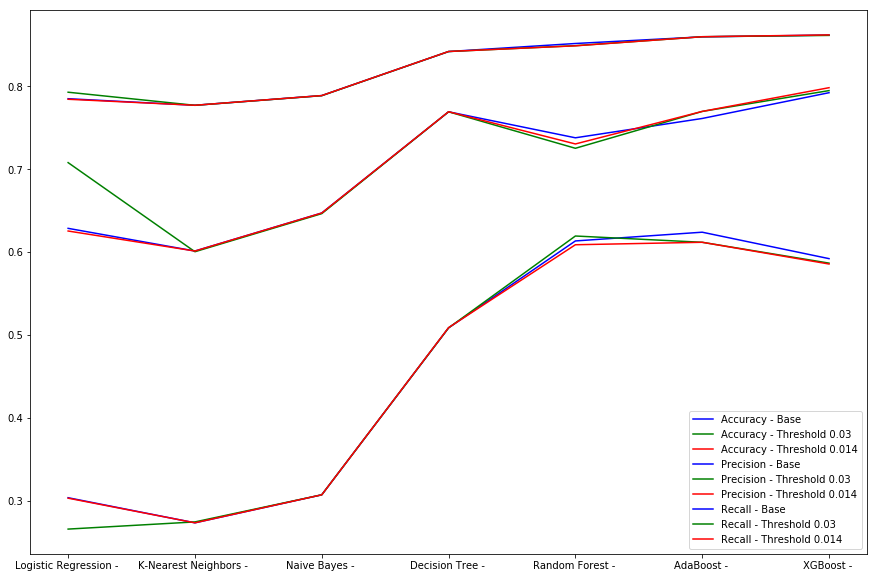

In [76]:
# Plotting the classification metrics for all the base models and models generated from features which have feature importance >=0.03, >=0.014

plt.figure(figsize=(15,10))
plt.plot(model_names , accuracy_base, label = "Accuracy - Base",c = 'blue')
plt.plot(model_names , accuracy_thresh_03, label = "Accuracy - Threshold 0.03", c = 'green')
plt.plot(model_names , accuracy_thresh_014, label = "Accuracy - Threshold 0.014", c= 'red')


plt.plot(model_names , precision_base, label = "Precision - Base",c = 'blue')
plt.plot(model_names , precision_thresh_03, label = "Precision - Threshold 0.03", c = 'green')
plt.plot(model_names , precision_thresh_014, label = "Precision - Threshold 0.014", c= 'red')


plt.plot(model_names , recall_base, label = "Recall - Base",c = 'blue')
plt.plot(model_names , recall_thresh_03, label = "Recall - Threshold 0.03", c = 'green')
plt.plot(model_names , recall_thresh_014, label = "Recall - Threshold 0.014",c= 'red')

plt.legend()
plt.show()

***Our base model with all the features performs as good as the models for which features were removed with a feature importance threshold of 0.03, 0.014.The difference recall and precision metrics along with accuracy are also too small to notice in models where the features are removed.So we stick with the  models with all the features***

***However, we choose Decision Tree, Random Forest, Adaboost and XGBoost classifiers for further optimization.***

# Validate Model

In [77]:
scoring = 'accuracy'
results=[]
names=[]
for classifier_name, model in classifiers:
    kfold = KFold(n_splits=10, random_state=100)
    cv_results = cross_val_score(model, x_train,y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(classifier_name)
    print(classifier_name,
                      "\n\t CV-Mean:", cv_results.mean(),
                    "\n\t CV-Std. Dev:",  cv_results.std(),"\n")

Logistic Regression -  
	 CV-Mean: 0.7868509700556264 
	 CV-Std. Dev: 0.004284707385989494 

K-Nearest Neighbors -  
	 CV-Mean: 0.7798556302086584 
	 CV-Std. Dev: 0.005827837382234451 

Naive Bayes -  
	 CV-Mean: 0.7885088169690938 
	 CV-Std. Dev: 0.006169737575906988 

Decision Tree -  
	 CV-Mean: 0.844108858379 
	 CV-Std. Dev: 0.008596489217638998 

Random Forest -  
	 CV-Mean: 0.8523309117476652 
	 CV-Std. Dev: 0.007133409747681625 

AdaBoost -  
	 CV-Mean: 0.8620121917445702 
	 CV-Std. Dev: 0.006018891855664965 

XGBoost -  
	 CV-Mean: 0.8598571621993495 
	 CV-Std. Dev: 0.005960042174289529 



In [78]:
scoring = 'f1'
results=[]
names=[]
for classifier_name, model in classifiers:
    kfold = KFold(n_splits=10, random_state=100)
    cv_results = cross_val_score(model, x_train,y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(classifier_name)
    print(classifier_name,
                      "\n\t CV-Mean:", cv_results.mean(),
                    "\n\t CV-Std. Dev:",  cv_results.std(),"\n")

Logistic Regression -  
	 CV-Mean: 0.4109305013935455 
	 CV-Std. Dev: 0.015178773073249765 

K-Nearest Neighbors -  
	 CV-Mean: 0.3884925024581391 
	 CV-Std. Dev: 0.01004596352177543 

Naive Bayes -  
	 CV-Mean: 0.4213398074876366 
	 CV-Std. Dev: 0.018451912575148527 

Decision Tree -  
	 CV-Mean: 0.6219431981576179 
	 CV-Std. Dev: 0.020764073640589367 

Random Forest -  
	 CV-Mean: 0.6804658187755593 
	 CV-Std. Dev: 0.013223569905487184 

AdaBoost -  
	 CV-Mean: 0.6924632840004245 
	 CV-Std. Dev: 0.014821128220726322 

XGBoost -  
	 CV-Mean: 0.6772151069014127 
	 CV-Std. Dev: 0.012789766416978925 



***We have better CV mean and Std deviation scores for Decision Tree, Random Forest, Adaboost and XGBoost classifiers than other classifiers. So these models are robust and in addition have good accuracy. I chose f1 as the CV parameter in addition to accuracy because precision and recall as metrics are just as important as accuracy in classification models.*** 

***We however, still need to optimize the hyper-parameters on these models.***

# Optimize or Tune Model for better Performance

## Decision Tree

In [79]:
param_grid = {'criterion':['gini','entropy'],
              'max_depth':[2, 3, 4,5, 6, 7, 8, 9],
              'random_state':[100],
              'splitter':['best']}

DT_grid = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv = 5, verbose=1)

In [80]:
DT_grid.fit(x_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    4.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9], 'random_state': [100], 'splitter': ['best']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [81]:
DT_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'random_state': 100,
 'splitter': 'best'}

In [82]:
model = DT_grid.best_estimator_
model.fit(x_train, y_train)
y_test_pred = model.predict(x_test)

In [83]:
model.score(x_test, y_test)

0.849203187250996

In [84]:
# Generate model evaluation metrics for the Decision Tree Classifier - Hyperparameter Tuned
print("Performance metrics of the model for the Decision Tree Classifier - Hyperparameter Tuned")
print("-"*100)
print("Accuracy: ", metrics.accuracy_score(y_test, y_test_pred))
print("Precision Score: ",metrics.precision_score(y_test, y_test_pred))
print("Recall Score: ",metrics.recall_score(y_test, y_test_pred))
print("AUROC Score: ",metrics.roc_auc_score(y_test,  y_test_pred_prob[:,1]))
print()
print("Confusion Matrix:  \n ",metrics.confusion_matrix(y_test, y_test_pred))
print()
print("Classification Report:\n ",metrics.classification_report(y_test, y_test_pred))

Performance metrics of the model for the Decision Tree Classifier - Hyperparameter Tuned
----------------------------------------------------------------------------------------------------
Accuracy:  0.849203187250996
Precision Score:  0.7975843398583924
Recall Score:  0.5175675675675676
AUROC Score:  0.9184356680624286

Confusion Matrix:  
  [[10874   486]
 [ 1785  1915]]

Classification Report:
               precision    recall  f1-score   support

          0       0.86      0.96      0.91     11360
          1       0.80      0.52      0.63      3700

avg / total       0.84      0.85      0.84     15060



In [85]:
DT_best = pickle.dumps(DT_grid.best_estimator_)

## Random Forest

In [86]:
param_grid = {'criterion':['gini','entropy'],
              'max_depth':[2, 3, 4, 5, 6, 7, 8, 9],
              'random_state':[100],
              'n_estimators':[200,400,600],
              'n_jobs':[-1], 
              'random_state':[100],
              'verbose': [0]}

RF_grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv = 5, verbose=1)

In [87]:
RF_grid.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  6.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9], 'random_state': [100], 'n_estimators': [200, 400, 600], 'n_jobs': [-1], 'verbose': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [88]:
RF_grid.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'n_estimators': 400,
 'n_jobs': -1,
 'random_state': 100,
 'verbose': 0}

In [89]:
model = RF_grid.best_estimator_
model.fit(x_train, y_train)
y_test_pred = model.predict(x_test)

In [90]:
model.score(x_test, y_test)

0.8523240371845949

In [91]:
# Generate model evaluation metrics for the RandomForest Classifier - Hyperparameter Tuned
print("Performance metrics of the model for the RandomForest Classifier - Hyperparameter Tuned")
print("-"*100)
print("Accuracy: ", metrics.accuracy_score(y_test, y_test_pred))
print("Precision Score: ",metrics.precision_score(y_test, y_test_pred))
print("Recall Score: ",metrics.recall_score(y_test, y_test_pred))
print("AUROC Score: ",metrics.roc_auc_score(y_test,  y_test_pred_prob[:,1]))
print()
print("Confusion Matrix:  \n ",metrics.confusion_matrix(y_test, y_test_pred))
print()
print("Classification Report:\n ",metrics.classification_report(y_test, y_test_pred))

Performance metrics of the model for the RandomForest Classifier - Hyperparameter Tuned
----------------------------------------------------------------------------------------------------
Accuracy:  0.8523240371845949
Precision Score:  0.7973408541498791
Recall Score:  0.5348648648648648
AUROC Score:  0.9184356680624286

Confusion Matrix:  
  [[10857   503]
 [ 1721  1979]]

Classification Report:
               precision    recall  f1-score   support

          0       0.86      0.96      0.91     11360
          1       0.80      0.53      0.64      3700

avg / total       0.85      0.85      0.84     15060



In [92]:
RF_best = pickle.dumps(RF_grid.best_estimator_)

## Adaboost

In [93]:
AdaBoostClassifier()

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [94]:
param_grid = {'algorithm':['SAMME.R'],
              'learning_rate':[0.1, 0.2, 0.3],
              'n_estimators':[200,400,600],
              'random_state':[100]}

AB_grid = GridSearchCV(AdaBoostClassifier(), param_grid=param_grid, cv = 5, verbose=1)

In [95]:
AB_grid.fit(x_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  4.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'algorithm': ['SAMME.R'], 'learning_rate': [0.1, 0.2, 0.3], 'n_estimators': [200, 400, 600], 'random_state': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [96]:
AB_grid.best_params_

{'algorithm': 'SAMME.R',
 'learning_rate': 0.3,
 'n_estimators': 600,
 'random_state': 100}

In [97]:
model = AB_grid.best_estimator_
model.fit(x_train, y_train)
y_test_pred = model.predict(x_test)

In [98]:
model.score(x_test, y_test)

0.8598937583001328

In [99]:
# Generate model evaluation metrics for the AdaBoost Classifier - Hyperparameter Tuned
print("Performance metrics of the model for the AdaBoost Classifier - Hyperparameter Tuned")
print("-"*100)
print("Accuracy: ", metrics.accuracy_score(y_test, y_test_pred))
print("Precision Score: ",metrics.precision_score(y_test, y_test_pred))
print("Recall Score: ",metrics.recall_score(y_test, y_test_pred))
print("AUROC Score: ",metrics.roc_auc_score(y_test,  y_test_pred_prob[:,1]))
print()
print("Confusion Matrix:  \n ",metrics.confusion_matrix(y_test, y_test_pred))
print()
print("Classification Report:\n ",metrics.classification_report(y_test, y_test_pred))

Performance metrics of the model for the AdaBoost Classifier - Hyperparameter Tuned
----------------------------------------------------------------------------------------------------
Accuracy:  0.8598937583001328
Precision Score:  0.7693089430894309
Recall Score:  0.6137837837837837
AUROC Score:  0.9184356680624286

Confusion Matrix:  
  [[10679   681]
 [ 1429  2271]]

Classification Report:
               precision    recall  f1-score   support

          0       0.88      0.94      0.91     11360
          1       0.77      0.61      0.68      3700

avg / total       0.85      0.86      0.85     15060



In [100]:
AB_best = pickle.dumps(AB_grid.best_estimator_)

## XGBoost

In [101]:
param_grid = {'learning_rate':[0.1, 0.2, 0.3],
              'max_depth':[2, 4, 7],
              'n_estimators':[200,400,600],
              'n_jobs':[-1], 
              'objective':['binary:logistic'],
              'random_state':[100],
              'reg_alpha':[0.1, 1, 10], 
              'scale_pos_weight':[1], 
              'silent':[True]}

XGB_grid = GridSearchCV(XGBClassifier(), param_grid=param_grid, cv = 5, verbose=1)

In [102]:
XGB_grid.fit(x_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed: 37.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [2, 4, 7], 'n_estimators': [200, 400, 600], 'n_jobs': [-1], 'objective': ['binary:logistic'], 'random_state': [100], 'reg_alpha': [0.1, 1, 10], 'scale_pos_weight': [1], 'silent': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [103]:
XGB_grid.best_params_

{'learning_rate': 0.2,
 'max_depth': 2,
 'n_estimators': 400,
 'n_jobs': -1,
 'objective': 'binary:logistic',
 'random_state': 100,
 'reg_alpha': 1,
 'scale_pos_weight': 1,
 'silent': True}

In [104]:
model = XGB_grid.best_estimator_
model.fit(x_train, y_train)
y_test_pred = model.predict(x_test)

In [105]:
model.score(x_test, y_test)

0.8682602921646746

In [106]:
# Generate model evaluation metrics for the XGBOOST - Hyperparameter Tuned
print("Performance metrics of the model for the XGBOOST Classifier - Hyperparameter Tuned")
print("-"*100)
print("Accuracy: ", metrics.accuracy_score(y_test, y_test_pred))
print("Precision Score: ",metrics.precision_score(y_test, y_test_pred))
print("Recall Score: ",metrics.recall_score(y_test, y_test_pred))
print("AUROC Score: ",metrics.roc_auc_score(y_test,  y_test_pred_prob[:,1]))
print()
print("Confusion Matrix:  \n ",metrics.confusion_matrix(y_test, y_test_pred))
print()
print("Classification Report:\n ",metrics.classification_report(y_test, y_test_pred))

Performance metrics of the model for the XGBOOST Classifier - Hyperparameter Tuned
----------------------------------------------------------------------------------------------------
Accuracy:  0.8682602921646746
Precision Score:  0.8124544792425346
Recall Score:  0.6029729729729729
AUROC Score:  0.9184356680624286

Confusion Matrix:  
  [[10845   515]
 [ 1469  2231]]

Classification Report:
               precision    recall  f1-score   support

          0       0.88      0.95      0.92     11360
          1       0.81      0.60      0.69      3700

avg / total       0.86      0.87      0.86     15060



In [107]:
XGB_best = pickle.dumps(XGB_grid.best_estimator_)

# Choose the model for deployment

***We choose the hyperparameter tuned models because they have the better accuracy score even though all other average metrics(from classification report) are the same.***

In [108]:
best_classifiers = [
                    ("Decision Tree - ",  DT_grid.best_estimator_),
                    ("Random Forest - ",  RF_grid.best_estimator_),
                    ("AdaBoost - ",  AB_grid.best_estimator_),
                    ("XGBoost - ", XGB_grid.best_estimator_)]
accuracy_best = []
precision_best = []
recall_best = []
best_model_names = [i[0] for i in best_classifiers]

for clf in best_classifiers:
    clf[1].fit(x_train[imp_cols], y_train)
    y_test_pred= clf[1].predict(x_test[imp_cols])
    accuracy_best.append(metrics.accuracy_score(y_test, y_test_pred))
    precision_best.append(metrics.precision_score(y_test, y_test_pred))
    recall_best.append(metrics.recall_score(y_test, y_test_pred)) 
    print(clf[0])
    print("-"*100)
    print("Accuracy: ", metrics.accuracy_score(y_test, y_test_pred))
    print("Precision Score: ",metrics.precision_score(y_test, y_test_pred))
    print("Recall Score: ",metrics.recall_score(y_test, y_test_pred))
    print("AUROC Score: ",metrics.roc_auc_score(y_test,  y_test_pred_prob[:,1]))
    print()
    print("Confusion Matrix:  \n ",metrics.confusion_matrix(y_test, y_test_pred))
    print()
    print("Classification Report:\n ",metrics.classification_report(y_test, y_test_pred))

Decision Tree - 
----------------------------------------------------------------------------------------------------
Accuracy:  0.849203187250996
Precision Score:  0.7975843398583924
Recall Score:  0.5175675675675676
AUROC Score:  0.9184356680624286

Confusion Matrix:  
  [[10874   486]
 [ 1785  1915]]

Classification Report:
               precision    recall  f1-score   support

          0       0.86      0.96      0.91     11360
          1       0.80      0.52      0.63      3700

avg / total       0.84      0.85      0.84     15060

Random Forest - 
----------------------------------------------------------------------------------------------------
Accuracy:  0.853054448871182
Precision Score:  0.7968063872255489
Recall Score:  0.5394594594594595
AUROC Score:  0.9184356680624286

Confusion Matrix:  
  [[10851   509]
 [ 1704  1996]]

Classification Report:
               precision    recall  f1-score   support

          0       0.86      0.96      0.91     11360
          1     

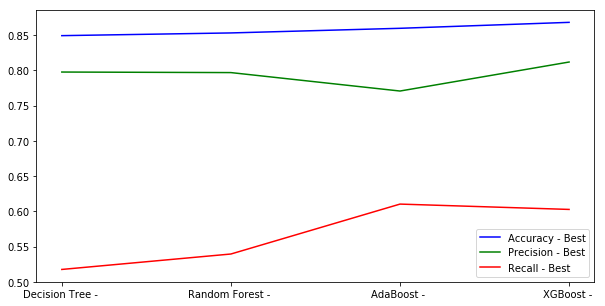

In [109]:
plt.figure(figsize=(10,5))
plt.plot(best_model_names , accuracy_best, label = "Accuracy - Best",c = 'blue')
plt.plot(best_model_names , precision_best, label = "Precision - Best", c = 'green')
plt.plot(best_model_names , recall_best, label = "Recall - Best",c= 'red')
plt.legend()
plt.show()

***Clearly XGBoost offers better Accuracy, Precision and Recall when compared to the other Classifiers. Therefore, we choose it as our model. The following are the hyper-parameters of the model:***

In [110]:
XGB_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=100, reg_alpha=1, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [111]:
# Saving the the chosen model in the pickle object
chosen_model = pickle.dumps(XGB_grid.best_estimator_)

In [112]:
#To Load:
pickle.loads(chosen_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=nan, n_estimators=400,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=100, reg_alpha=1, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)